# Setting up

In [1]:
!pip install numpy>=2.0 Cython scipy torch matplotlib dipy==1.10.0 torchvision Pillow scikit-image tqdm -v

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from dipy.data import read_stanford_t1
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, CenterCrop
import numpy as np
import skimage
import matplotlib.pyplot as plt

from tqdm import tqdm

import time
import math

Let's start by creating some functions for data loading.

In [3]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
    
def get_t1_tensor(sidelength):
    t1 = read_stanford_t1().get_fdata().astype(float)
    t1 = (t1 - t1.min()) / (t1.max() - t1.min())
    img = Image.fromarray(t1[:, :, 40].T)        
    transform = Compose([
        CenterCrop([max(t1.shape)-5, max(t1.shape)-5]),
        Resize([sidelength, sidelength]),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

And our actual dataset. It will load a single image and return coordinates for its pixels as values, and the corresponding values as targets. We'll also have a look at the image's gradients and laplacian as the model is training so let's define some functions for these. We'll use torch's autograd to simplify the implementation.

In [4]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [5]:
import scipy.ndimage
    
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_t1_tensor(sidelength)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace).view(-1, 1)
        print(self.laplace.shape, self.grads.shape)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

# ReLU MLP

Let's declare a simple MLP with ReLU activations.

In [6]:
class ReLULayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False):
        super().__init__()
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        return self.relu(self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.linear(input)
        return self.relu(intermediate), intermediate
    
    
class ReLUNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False):
        super().__init__()
        
        self.net = []
        self.net.append(ReLULayer(in_features, hidden_features, 
                                  is_first=True))

        for i in range(hidden_layers):
            self.net.append(ReLULayer(hidden_features, hidden_features, 
                                      is_first=False))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
                
            self.net.append(final_linear)
        else:
            self.net.append(ReLULayer(hidden_features, out_features, 
                                      is_first=False))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        
        return activations

Let's define the loss (MSE) that we'll use to train our model.

In [7]:
def mse(model_output, coords, gt):
    # compare them with the ground-truth
    loss = torch.mean((model_output - gt['pixels'].cuda()).pow(2).sum(-1))
    return loss

And the actual training function.

In [8]:
def train(model, dataloader, loss_fn, sidelen=84, n_epochs=6000):

    total_steps = n_epochs # Since the whole image is our dataset, this just means 500 gradient descent steps.
    steps_til_summary = 1000
    
    optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
    
    model_input, ground_truth = next(iter(dataloader))
    model_input = model_input.cuda()
    
    for step in range(total_steps):
        model_output, coords = model(model_input)    
        loss = loss_fn(model_output, coords, ground_truth).mean()
        
        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
            img_grad = gradient(model_output, coords)
            img_laplacian = laplace(model_output, coords)
    
            fig, axes = plt.subplots(1,3, figsize=(18,6))
            axes[0].imshow(model_output.cpu().view(sidelen,sidelen).detach().numpy())
            axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelen,sidelen).detach().numpy())
            axes[2].imshow(img_laplacian.cpu().view(sidelen,sidelen).detach().numpy())
            plt.show()
    
        optim.zero_grad()
        loss.backward()
        optim.step()

Finally ! Let's instanciate everything and train our model !

To recap, our model 

$$f_\theta(x) \rightarrow \hat{y} $$ 

is a simple MLP with ReLU activations

$$x \rightarrow \phi (x) = \text{max}(0, Wx + b) $$

. The model takes as input 2D coordinates $x \in \mathbb{R}^2$ and outputs $\hat{y} \in [0, 1]$ the image's values. The model is trained via MSE, ie

$$L_\theta(y, \hat{y}) = \frac{1}{N}\sum(y_i - \hat{y}_i)^2$$

torch.Size([7056, 1]) torch.Size([7056, 2])


/home/thea1603/workspace/vitalab.github.io/.env/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, Total loss 0.510411


/home/thea1603/workspace/vitalab.github.io/.env/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


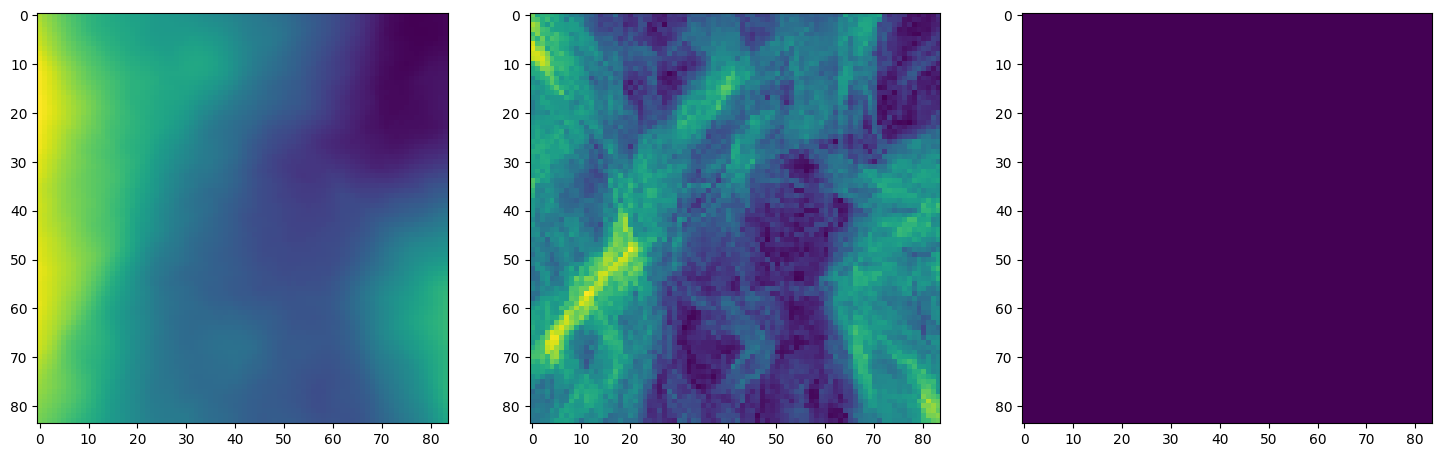

Step 1000, Total loss 0.040383


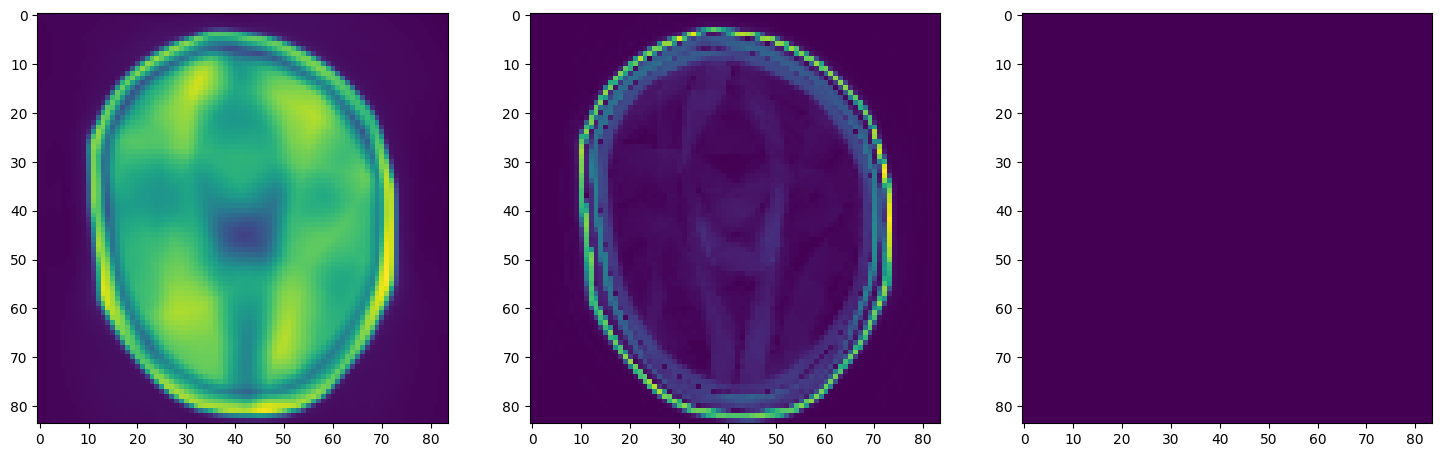

Step 2000, Total loss 0.026653


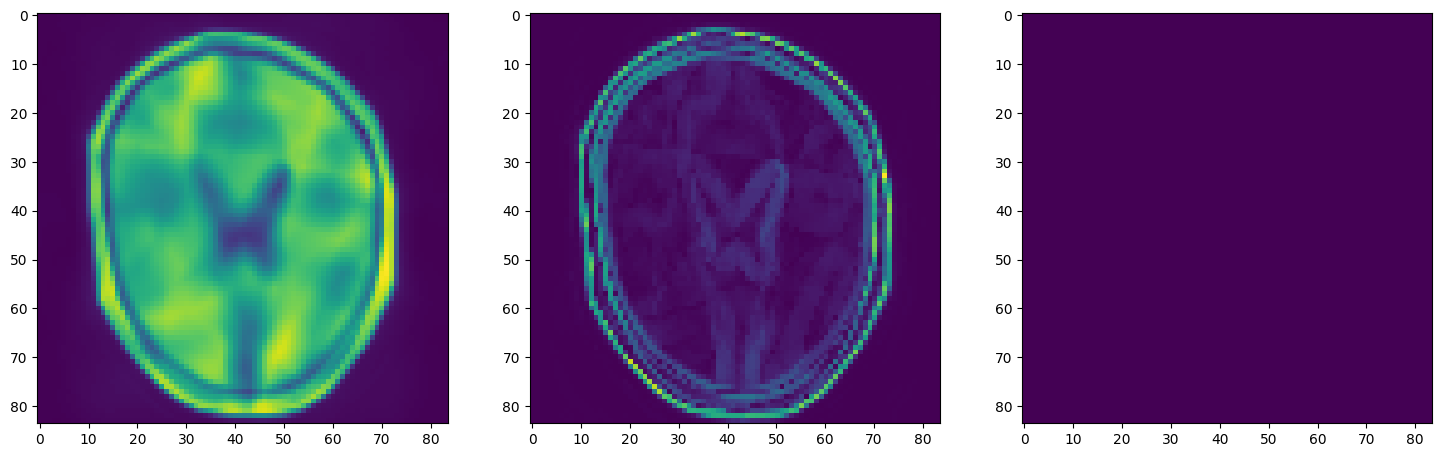

Step 3000, Total loss 0.021786


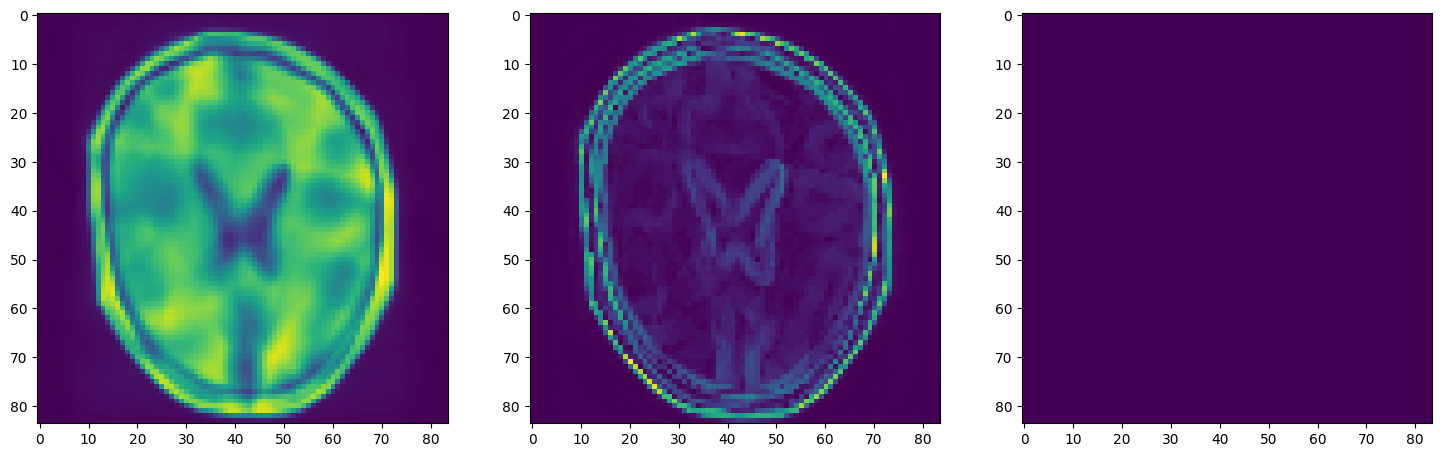

Step 4000, Total loss 0.018965


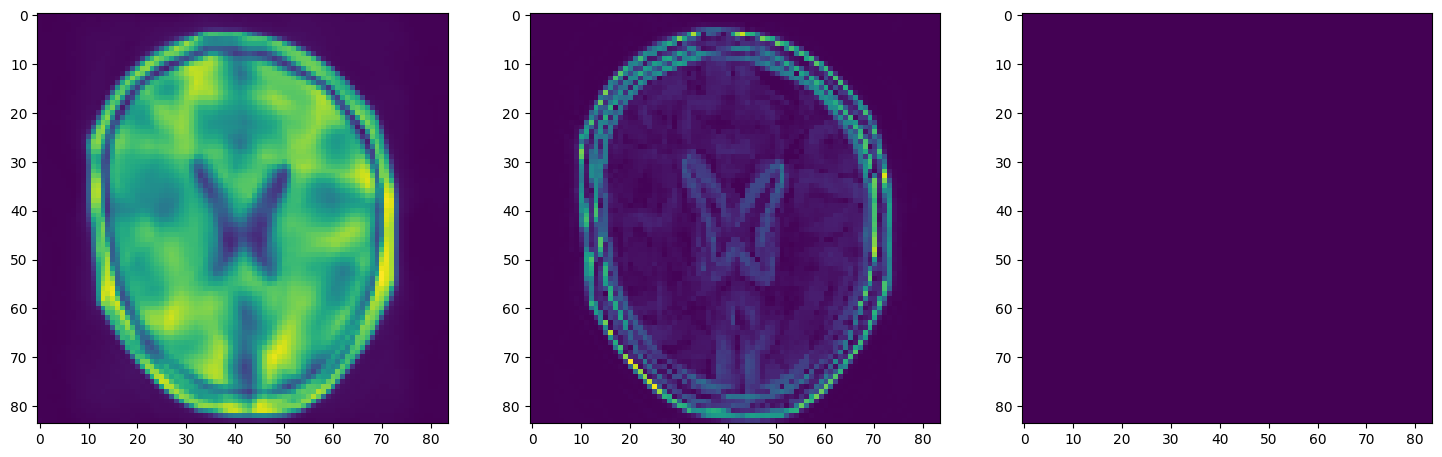

Step 5000, Total loss 0.017580


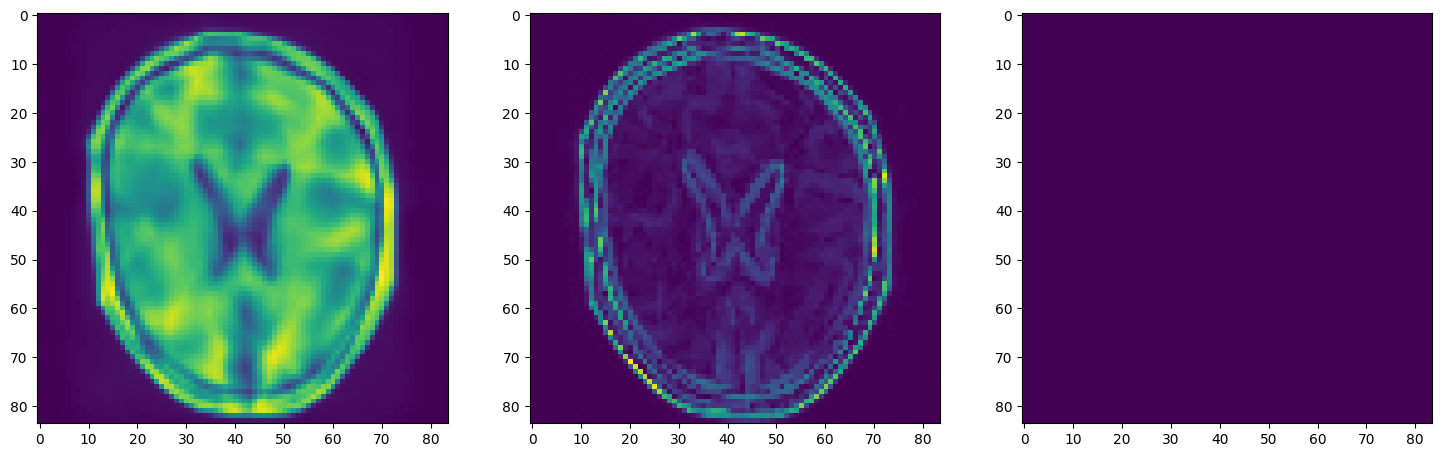

In [9]:
t1 = ImageFitting(84)
dataloader = DataLoader(t1, batch_size=1, pin_memory=True, num_workers=0)

model = ReLUNet(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=4, outermost_linear=True)
model.cuda()

train(model, dataloader, mse)

Hmmm, the results aren't amazing. Apparently, the "killer app" for INRs is free interpolation. Let's try that.

In [10]:
def get_t1_at_res(model, res, batch_size=128):
    with torch.no_grad():
        coords = get_mgrid(res, 2)
        inpt = coords.cuda()
        model_output, _ = model(inpt)
        reconst = model_output.view(res, res).cpu().detach().numpy()
        
    return reconst
    

In [11]:
from scipy import ndimage
def eval_model(model):
    res=84
    fig, axes = plt.subplots(2,3, figsize=(16,8))
    t1 = get_t1_tensor(res).numpy().squeeze()
    axes[0, 0].set_title(f'Original image ({res}x{res}).')
    axes[0, 0].imshow(t1, interpolation='nearest', cmap='gray')
    t1_512 = ndimage.zoom(t1, 4, order=2)
    axes[0, 1].set_title(f'Original image, resized at {res*4}x{res*4}).')
    axes[0, 1].imshow(t1_512[50:250, 50:250], interpolation='nearest', cmap='gray')
    t1_1024 = ndimage.zoom(t1, 8, order=2)
    axes[0, 2].set_title(f'Original image, resized at {res*8}x{res*8}')
    axes[0, 2].imshow(t1_1024[100:500, 100:500], interpolation='nearest', cmap='gray')
    cam_256 = get_t1_at_res(model, res)
    axes[1, 0].set_title(f'Predicted image at {res}x{res}')
    axes[1, 0].imshow(cam_256, interpolation='nearest', cmap='gray')
    cam_512 = get_t1_at_res(model, res*4)
    axes[1, 1].set_title(f'Predicted image at {res*4}x{res*4}')
    axes[1, 1].imshow(cam_512[50:250, 50:250], interpolation='nearest', cmap='gray')
    cam_1024 = get_t1_at_res(model, res*8)
    axes[1, 2].set_title(f'Predicted image at {res*8}x{res*8}')
    axes[1, 2].imshow(cam_1024[100:500, 100:500], interpolation='nearest', cmap='gray')


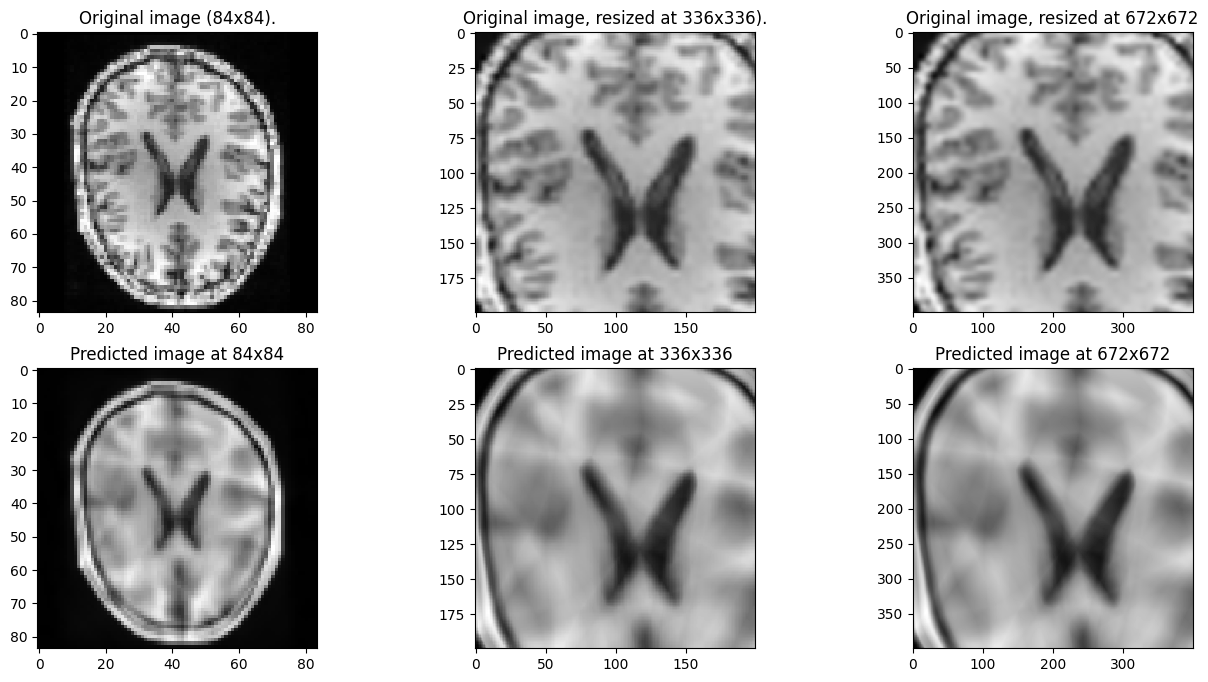

In [12]:
eval_model(model)

Still not great. That is because ReLU is biased towards low-frequency functions [1,2] because it is piece-wise linear and will force any model using it to learn them first. We could fix the problem by adding more layers and more parameters, but we'll use a better solution instead: replacing ReLU with a continuous activation function.


[1]:  Rahaman, N., Baratin, A., Arpit, D., Draxler, F., Lin, M., Hamprecht, F., Bengio, Y. &amp; Courville, A.. (2019). On the Spectral Bias of Neural models. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:5301-5310 Available from https://proceedings.mlr.press/v97/rahaman19a.html.

[2]: Sitzmann, V., Martel, J., Bergman, A., Lindell, D., &amp; Wetzstein, G. (2020). Implicit neural representations with periodic activation functions. Advances in neural information processing systems, 33, 7462-7473.

# Sinusoidal networks

In [1], the authors propose to counter the low-frequency bias of ReLU by replacing it with a sine function, such that
$$ x \rightarrow \phi(x; \omega_0) = \text{sin}(\omega_0 Wx + b) .$$ sin is indeed not piecewise-linear and therefore should not be biased towards low-frequency functions. However, many other activation functions, such as tanh or sigmoid, are also continuous. Why choose sin then ? Because the derivative of sin is cosine, which is just a phase-shifted sin. We'll see later why that is interesting, but for now let's define a SInusoidal REpresentatioN (SIREN) model.


[1]: Sitzmann, V., Martel, J., Bergman, A., Lindell, D., &amp; Wetzstein, G. (2020). Implicit neural representations with periodic activation functions. Advances in neural information processing systems, 33, 7462-7473.

In [13]:
class SineLayer(nn.Module):
    # The paper includes discussion on the initialization of SIREN weights, which will
    # impact its initial frequency. See [1] for more information.
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

Let's declaire a SIREN instead of a ReLU MLP, but with the same number of parameters.

In [14]:
t1 = ImageFitting(84)
dataloader = DataLoader(t1, batch_size=1, pin_memory=True, num_workers=0)

model = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=4, outermost_linear=True)
model.cuda()

torch.Size([7056, 1]) torch.Size([7056, 2])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

And let's train it ! 

Step 0, Total loss 0.502087


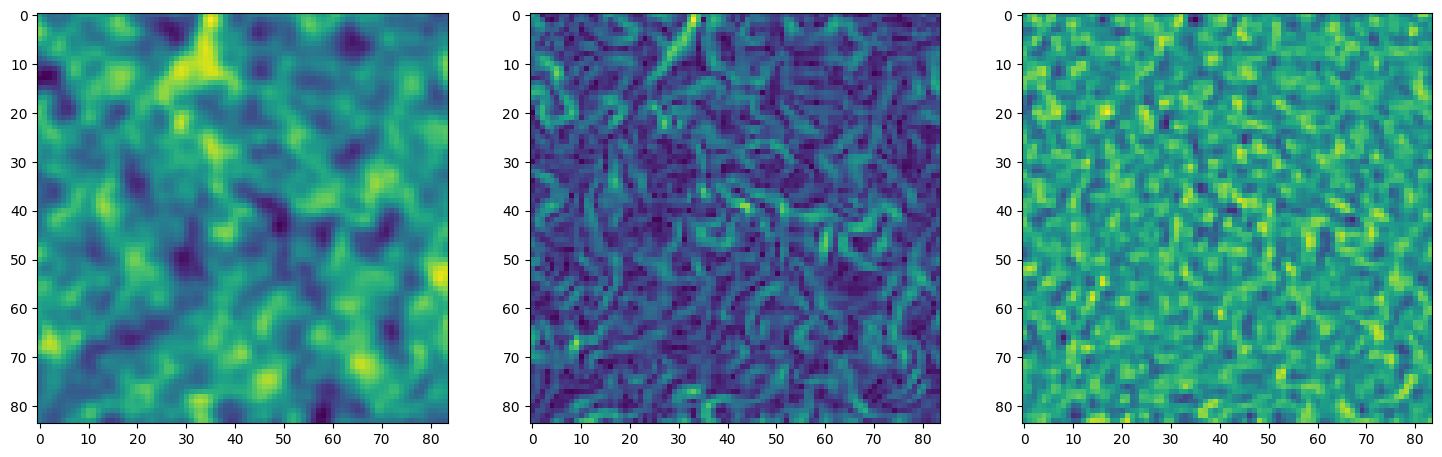

Step 1000, Total loss 0.000000


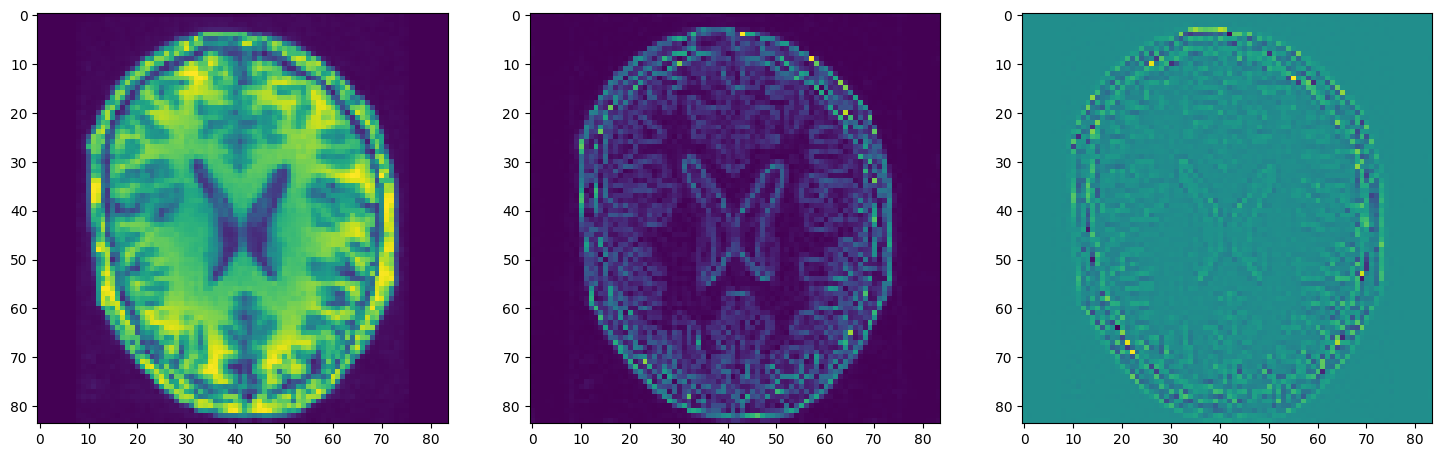

Step 2000, Total loss 0.000000


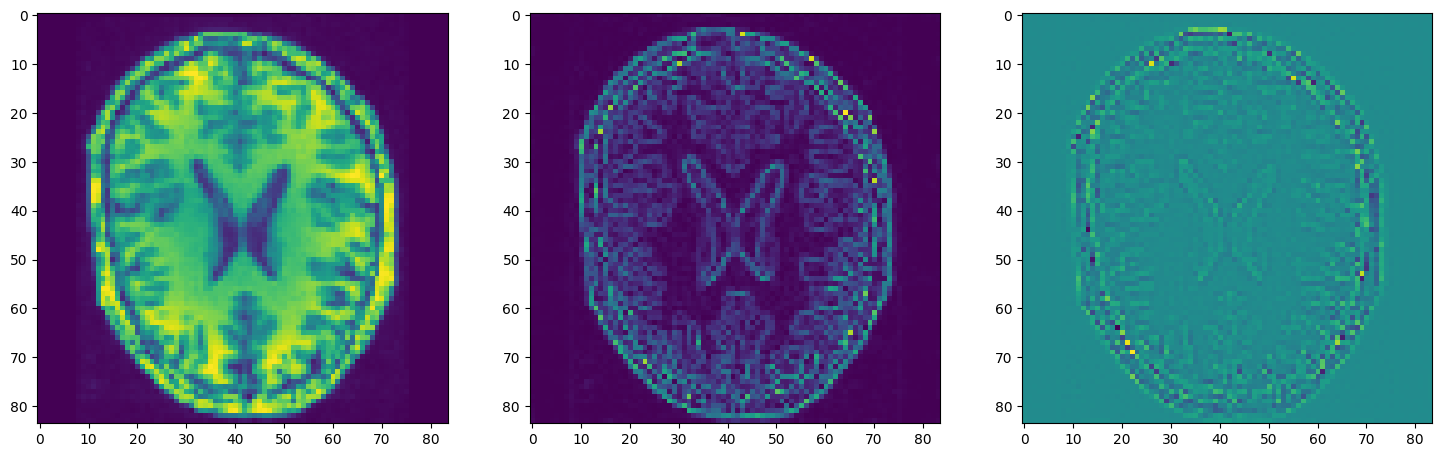

Step 3000, Total loss 0.000000


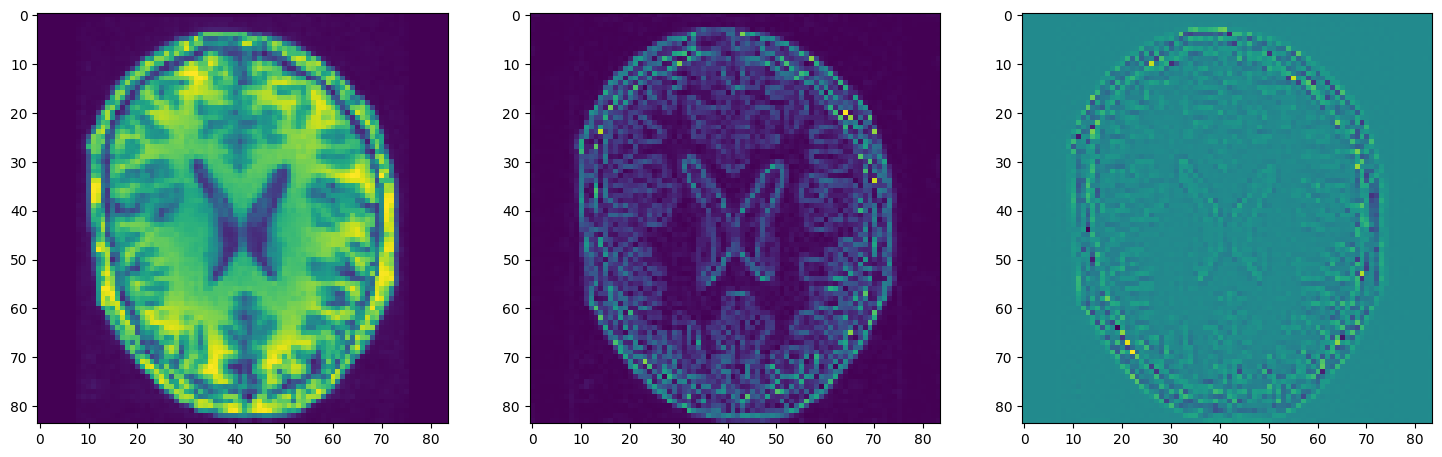

Step 4000, Total loss 0.000010


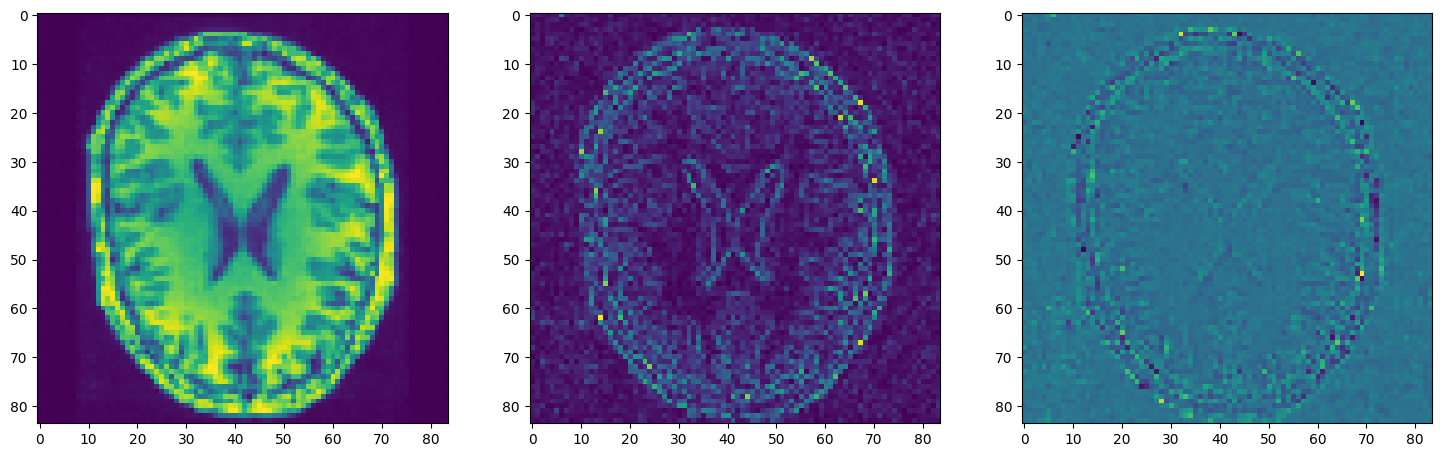

Step 5000, Total loss 0.000000


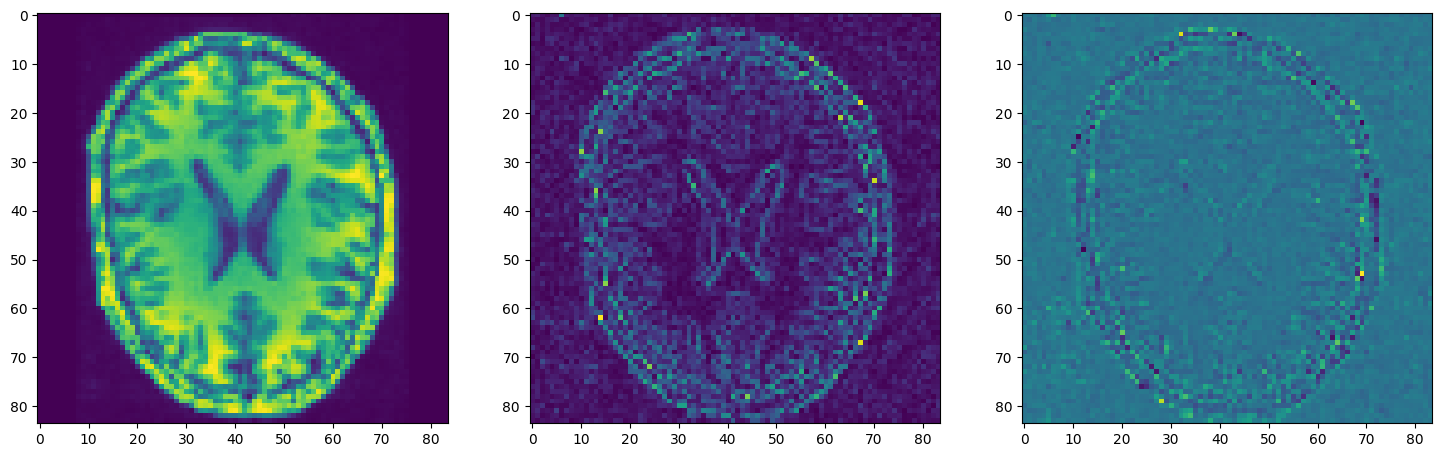

In [15]:
train(model, dataloader, mse)

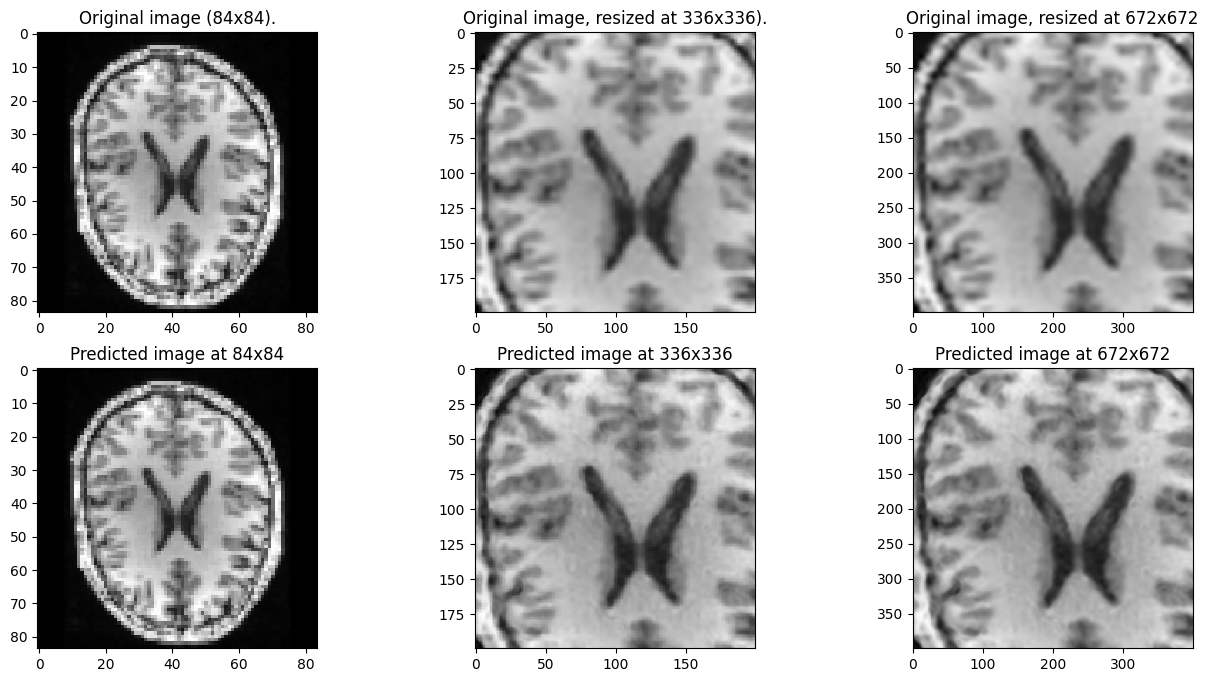

In [16]:
eval_model(model)

It works ! The image can be "interpolated" at any resolution by sampling more points. The image isn't as sharp as it could be, but the results could probably be improved with more training and more parameters.

As mentionned earlier, the derivative of a sine function is cosine, which is just a phase-shifted sine. The authors of SIREN actually argue that the derivative of a SIREN is still a SIREN, which allows it to learn not only from targets, but also from the gradients of targets. From the paper

> We demonstrate that the proposed representation is not only able to accurately represent a function and its derivatives, but that it can also be supervised solely by its derivatives, i.e., the model is never presented with the actual function values, but only values of its first or higher-order derivatives

The authors demonstrate this by training SIREN on the derivative of the image, instead of its actual values, such that the loss becomes 

$$L_\theta(x) = \int_x||\nabla_x \phi(x) - \nabla_x f(x)|| dx.$$

Let's define our new loss function:

In [17]:
def gradients_mse(model_output, coords, gt):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    loss = torch.mean((gradients - gt['grads'].cuda()).pow(2).sum(-1))
    return loss

And train our model: 

In [18]:
t1 = ImageFitting(84)
dataloader = DataLoader(t1, batch_size=1, pin_memory=True, num_workers=0)

model = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=4, outermost_linear=True)
model.cuda()

torch.Size([7056, 1]) torch.Size([7056, 2])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 65.306503


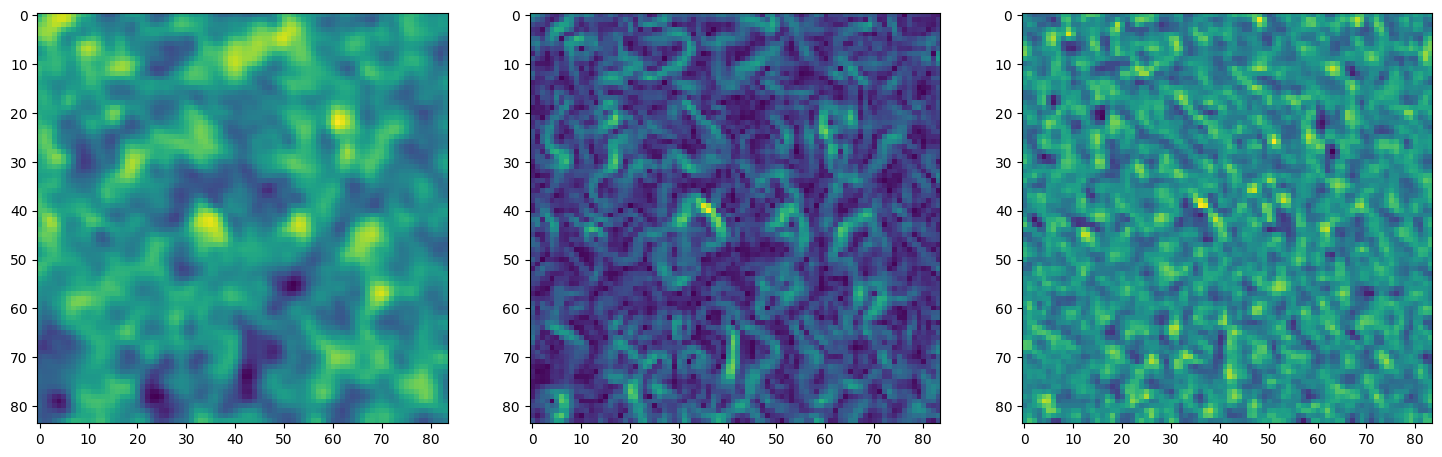

Step 1000, Total loss 0.005259


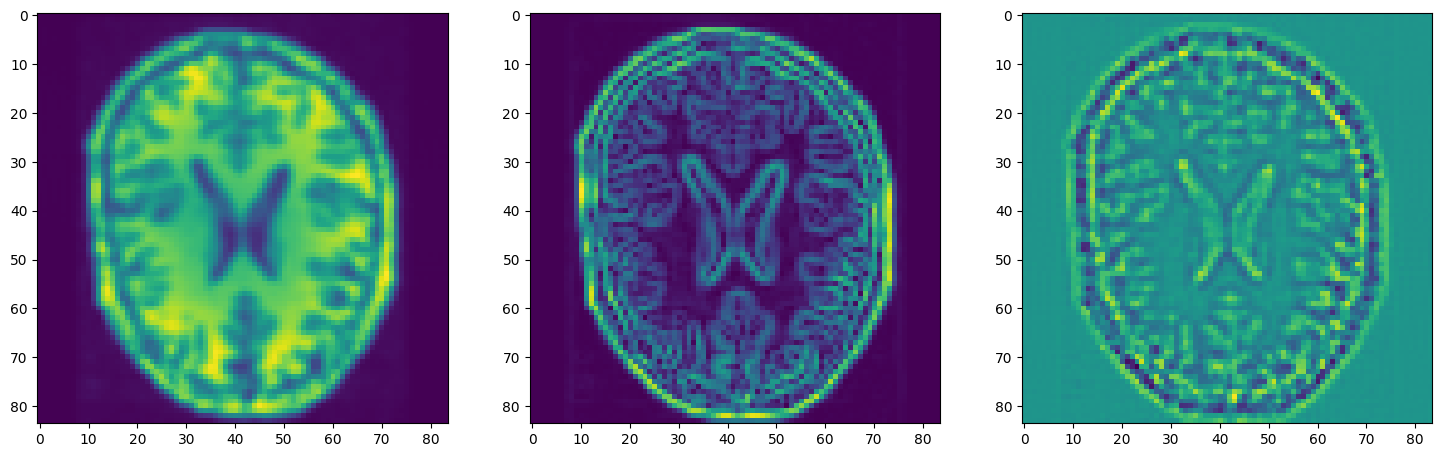

Step 2000, Total loss 0.000441


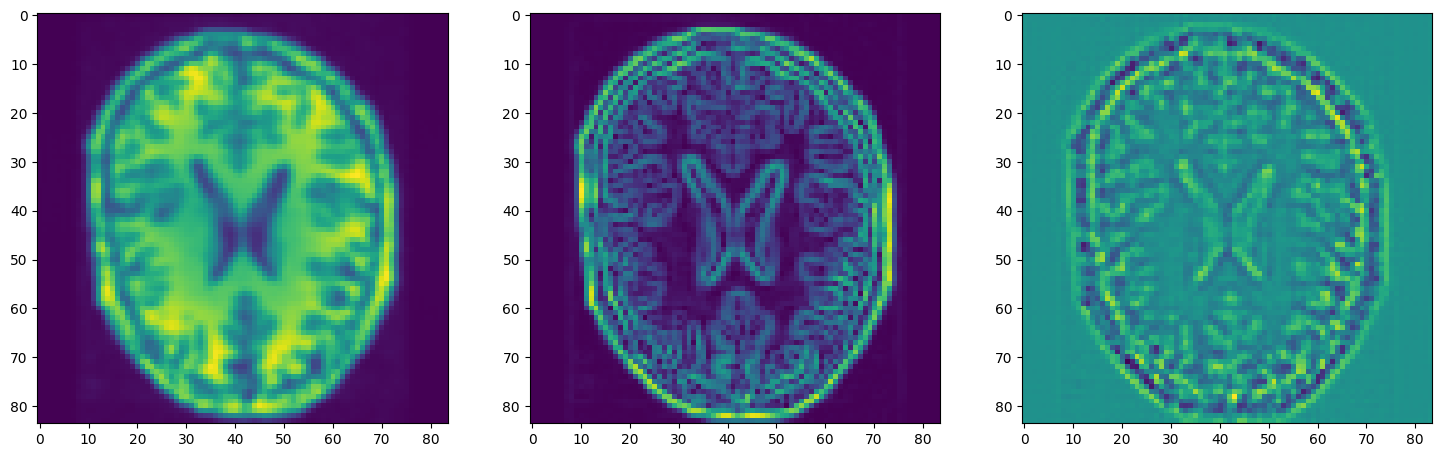

Step 3000, Total loss 0.000512


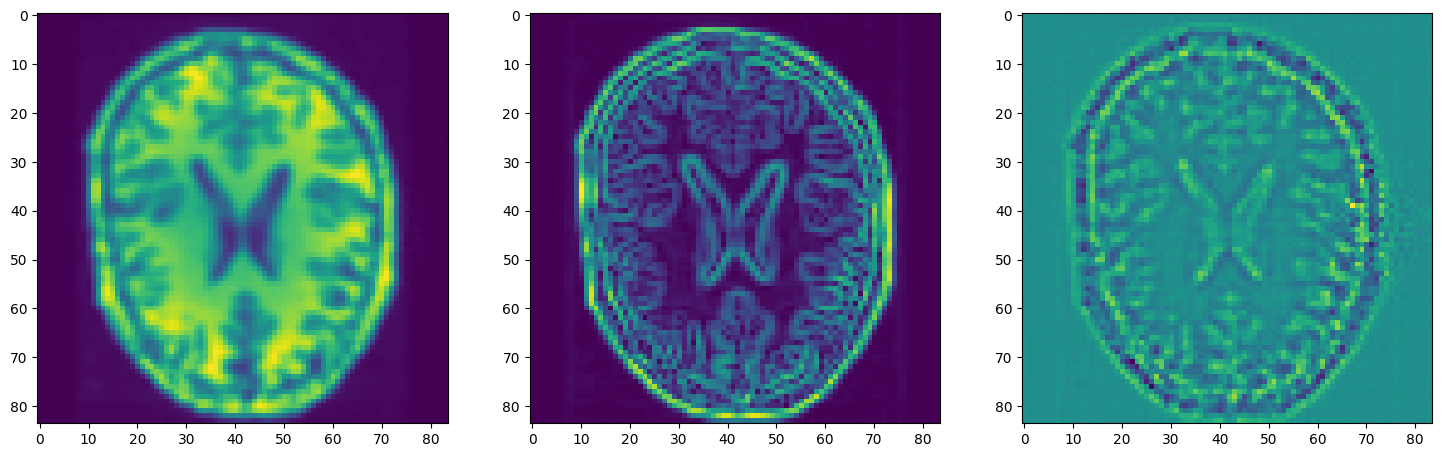

Step 4000, Total loss 0.000434


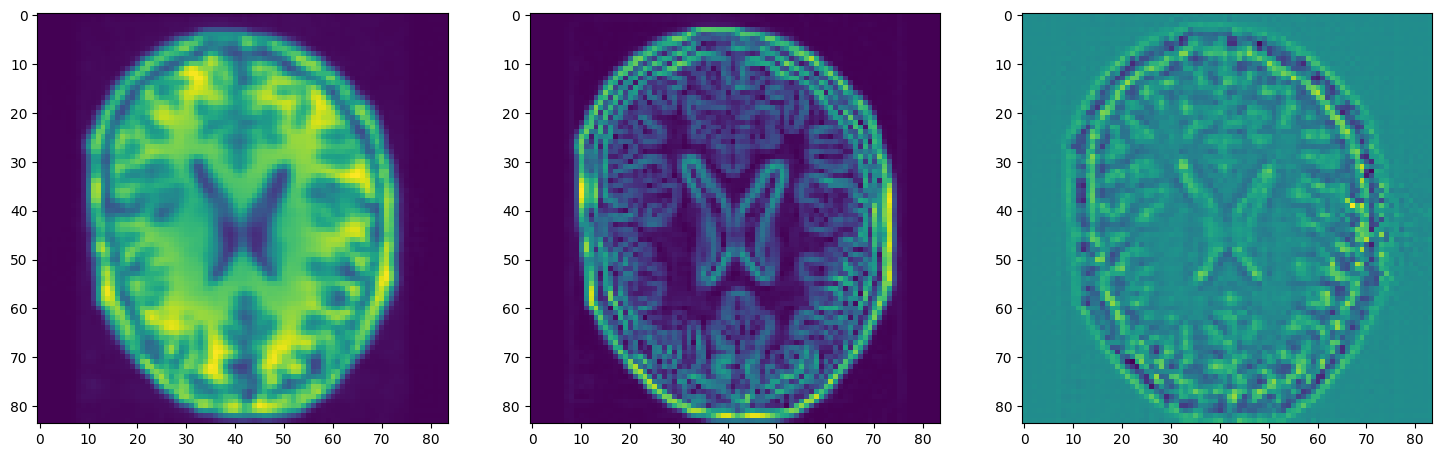

Step 5000, Total loss 0.000126


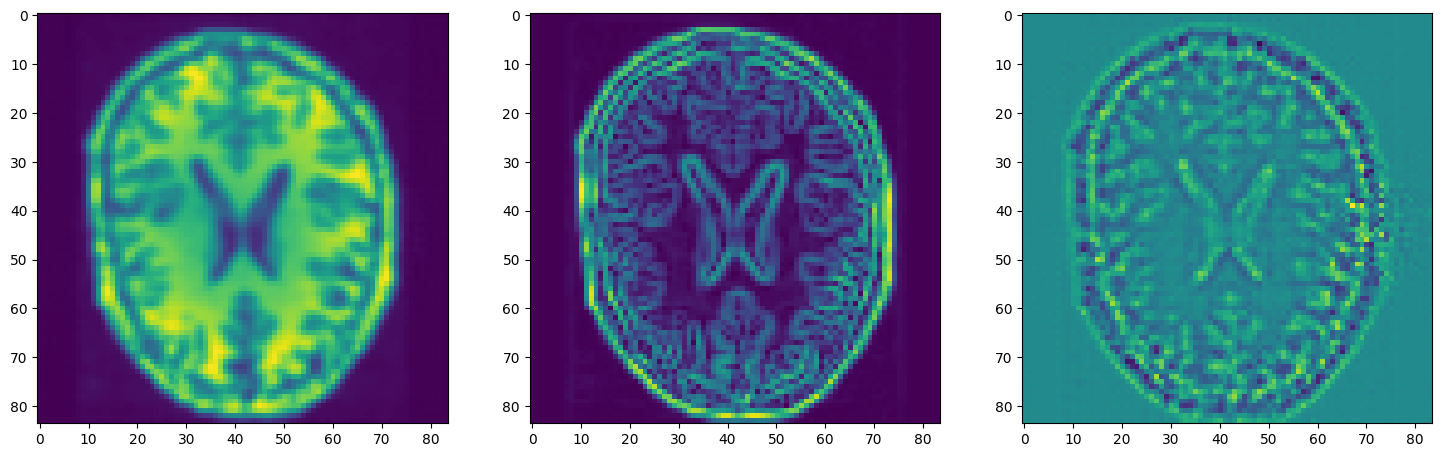

In [19]:
train(model, dataloader, gradients_mse)

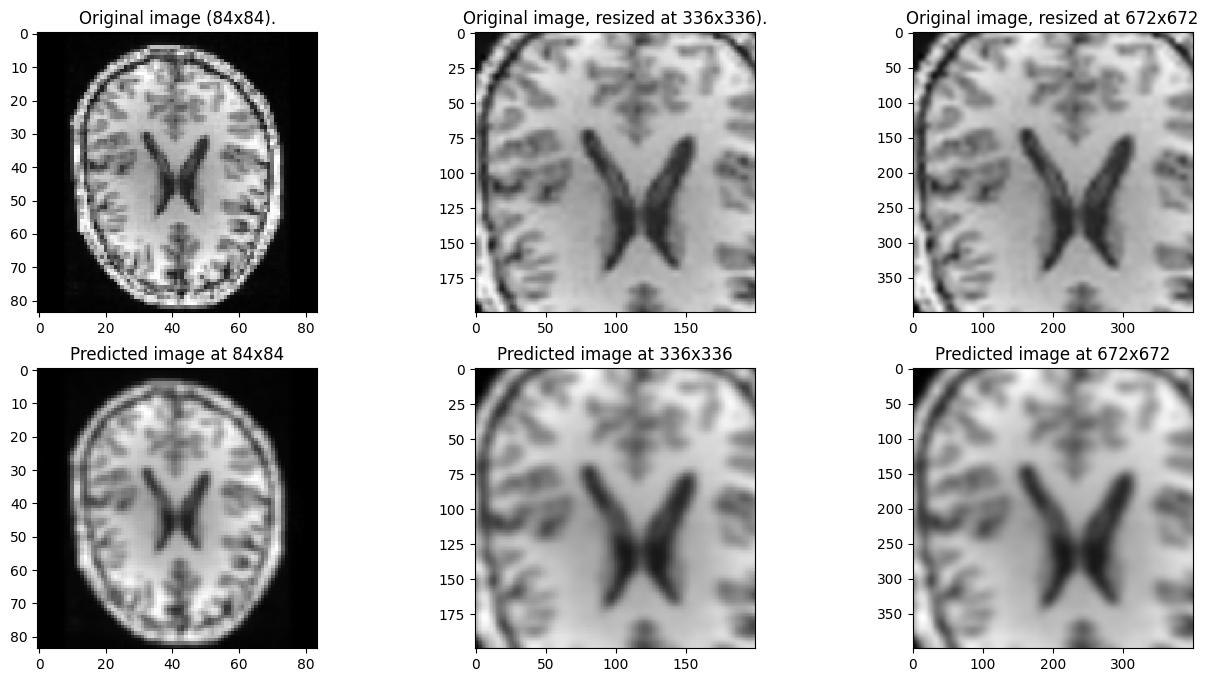

In [20]:
eval_model(model)

As we can see, the results are slightly worse than previously, but it is still a neat property. Note that this is possible not only with gradients but also with the laplacian. This is useful for problems where the gradients or laplacian are well defined (such in the case of PDEs, for example) but not the actual values.

# Fourier encoding

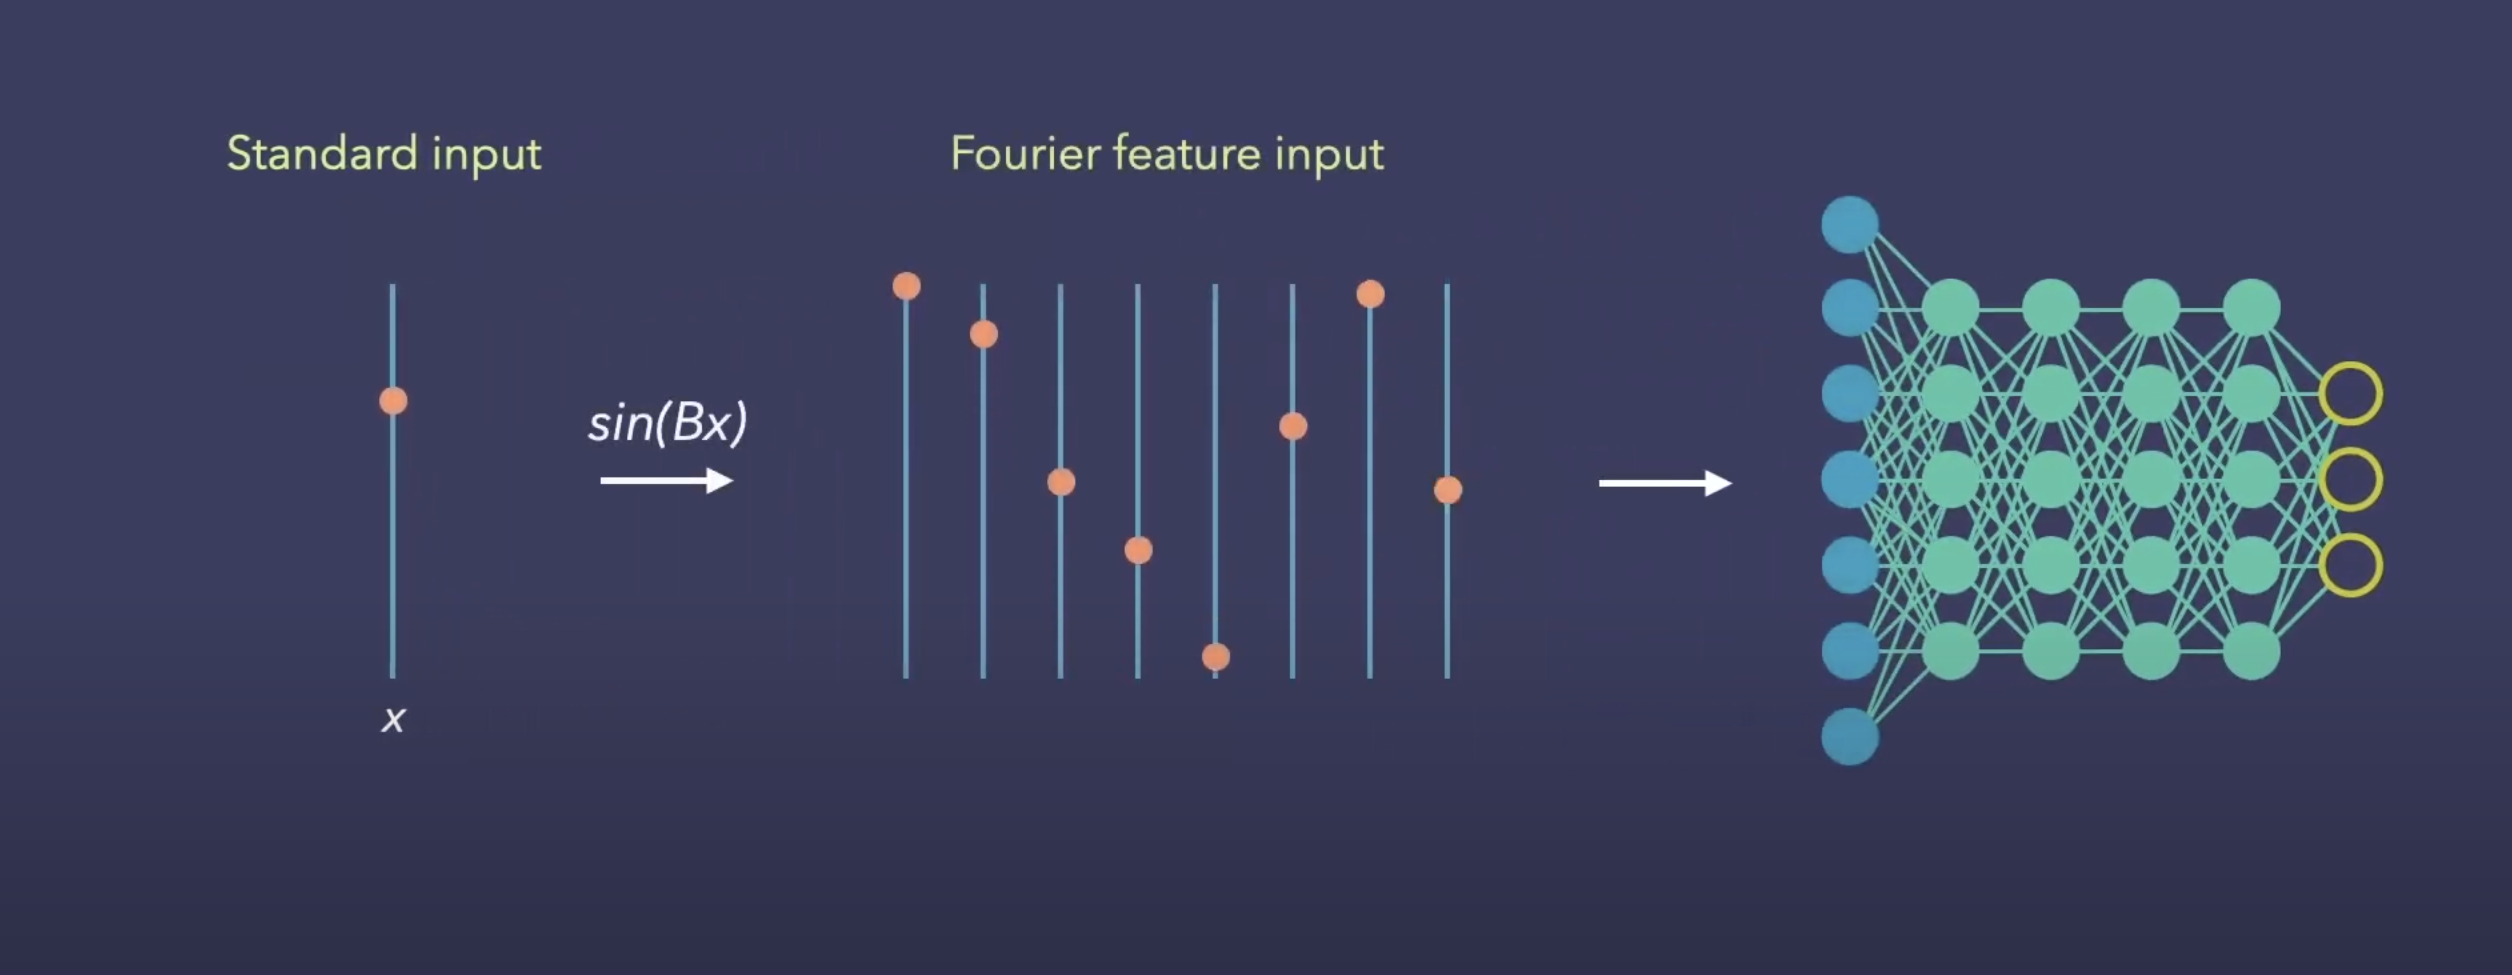 [1]


While sinusoidal activation functions offer nice properties, ReLU is still appealing due to its ubiquity and ease of implementation. Fortunately, there is a way to use simple ReLU MLP for INR. In [2], the authors propose to first encode the coordinates using a Fourier feature mapping, then feed them to a ReLU MLP.

The Fourier feature mapping $\gamma(x)$ is essentially the Fourier series expansion of the input vector:

$$\gamma(x) = [\text{cos}(2 \pi Bx), \text{sin}(2 \pi Bx)]^T,$$

where $B \in \mathbb{R}^{2 \times M}$ represents, in the case of 2D coordinates, $M$ random sine functions sampled from a standard Gaussian distribution. $\gamma(x)$ can then be input to a standard ReLU MLP.


\[1]: https://www.youtube.com/watch?v=nVA6K6Sn2S4

\[2]: Tancik, M., Srinivasan, P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., ... & Ng, R. (2020). Fourier features let networks learn high frequency functions in low dimensional domains. Advances in neural information processing systems, 33, 7537-7547.

In [21]:
import torch
from torch import nn

class FourierFeatures(nn.Module):
    """ Positional encoder from Fourite Features [Tancik et al. 2020]
     Implementation based on https://github.com/tancik/fourier-feature-networks/blob/master/Demo.ipynb """
    def __init__(self,
                 coord_size: int,
                 freq_num: int,
                 freq_scale: float = 1.0):
        super().__init__()
        self.freq_num = freq_num  # Number of frequencies
        self.freq_scale = freq_scale  # Standard deviation of the frequencies
        self.B_gauss = torch.normal(0.0, 1.0, size=(coord_size, self.freq_num)) * self.freq_scale

        # We store the output size of the module so that the INR knows what input size to expect
        self.out_size = 2 * self.freq_num

    def forward(self, coords):
        # Map the coordinates to a higher dimensional space using the randomly initialized features
        b_gauss_pi = 2. * torch.pi * self.B_gauss.to(coords.device)
        prod = coords @ b_gauss_pi
        # Pass the features through a sine and cosine function
        out = torch.cat((torch.sin(prod), torch.cos(prod)), dim=-1)
        return out

In [22]:
FF_FREQS = 128
FF_SCALE = 1.0    
    
class PosEncReLUNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features):
        super().__init__()
        
        self.net = [FourierFeatures(in_features, FF_FREQS, FF_SCALE)]

        for i in range(hidden_layers):
            self.net.append(ReLULayer(hidden_features, hidden_features, 
                                      is_first=False))

        final_linear = nn.Linear(hidden_features, out_features)
                
        self.net.append(final_linear)
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        
        return activations

In [23]:
t1 = ImageFitting(84)
dataloader = DataLoader(t1, batch_size=1, pin_memory=True, num_workers=0)

model = PosEncReLUNet(in_features=2, out_features=1, hidden_features=256, 
                hidden_layers=4)
model.cuda()

torch.Size([7056, 1]) torch.Size([7056, 2])


PosEncReLUNet(
  (net): Sequential(
    (0): FourierFeatures()
    (1): ReLULayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (relu): ReLU()
    )
    (2): ReLULayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (relu): ReLU()
    )
    (3): ReLULayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (relu): ReLU()
    )
    (4): ReLULayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (relu): ReLU()
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.534471


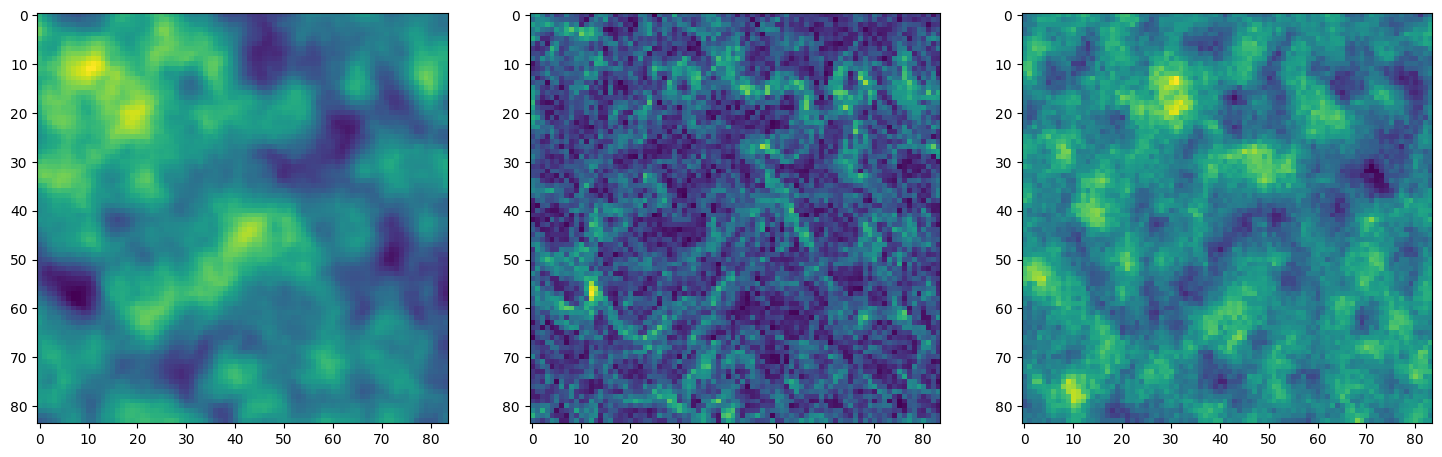

Step 1000, Total loss 0.001843


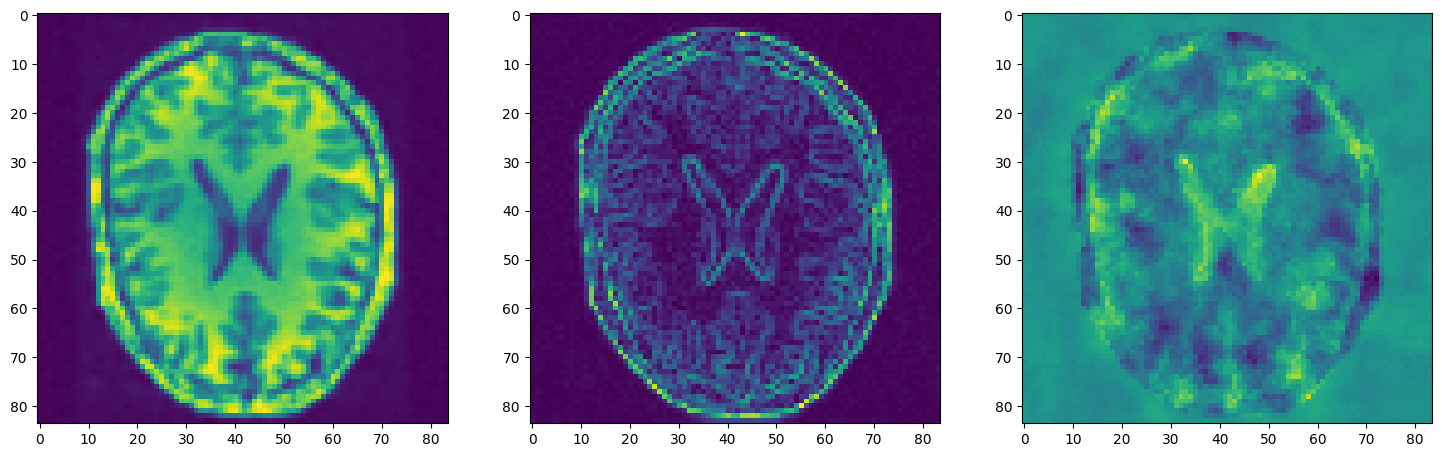

Step 2000, Total loss 0.000564


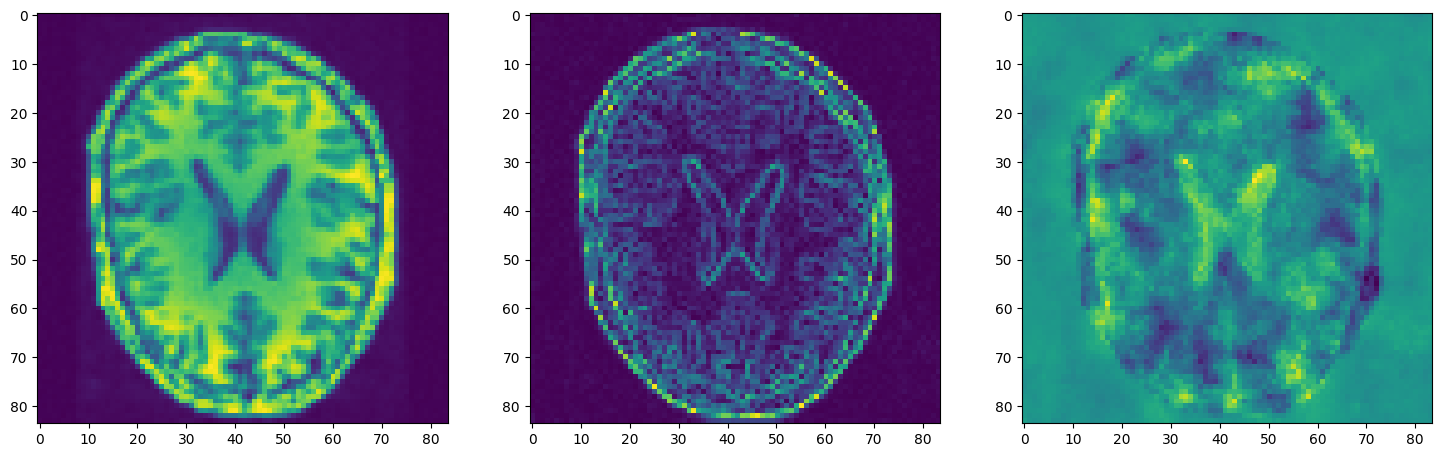

Step 3000, Total loss 0.000267


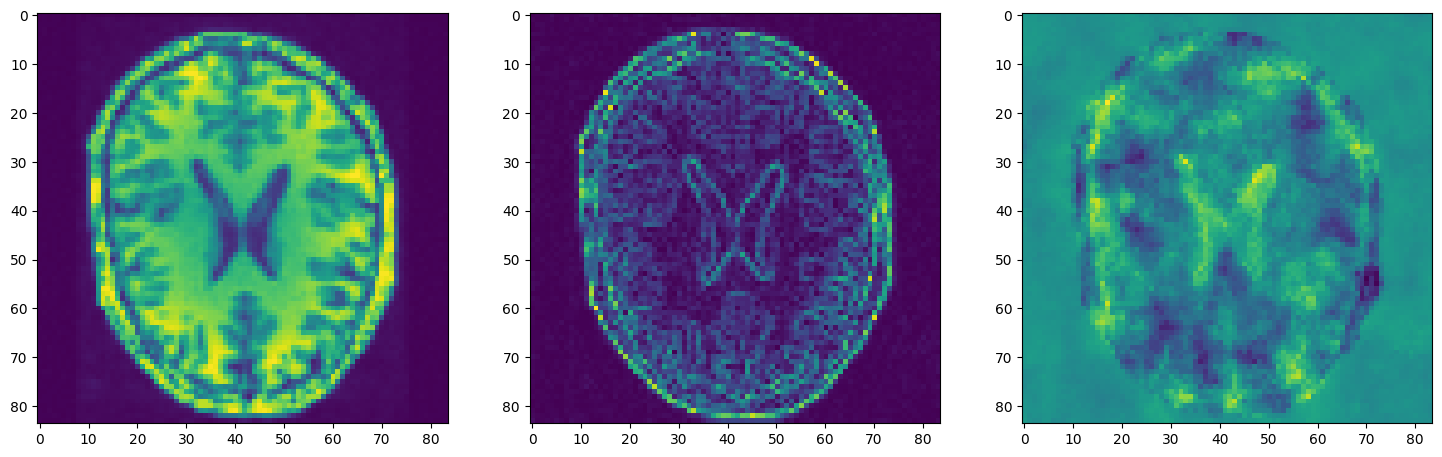

Step 4000, Total loss 0.000647


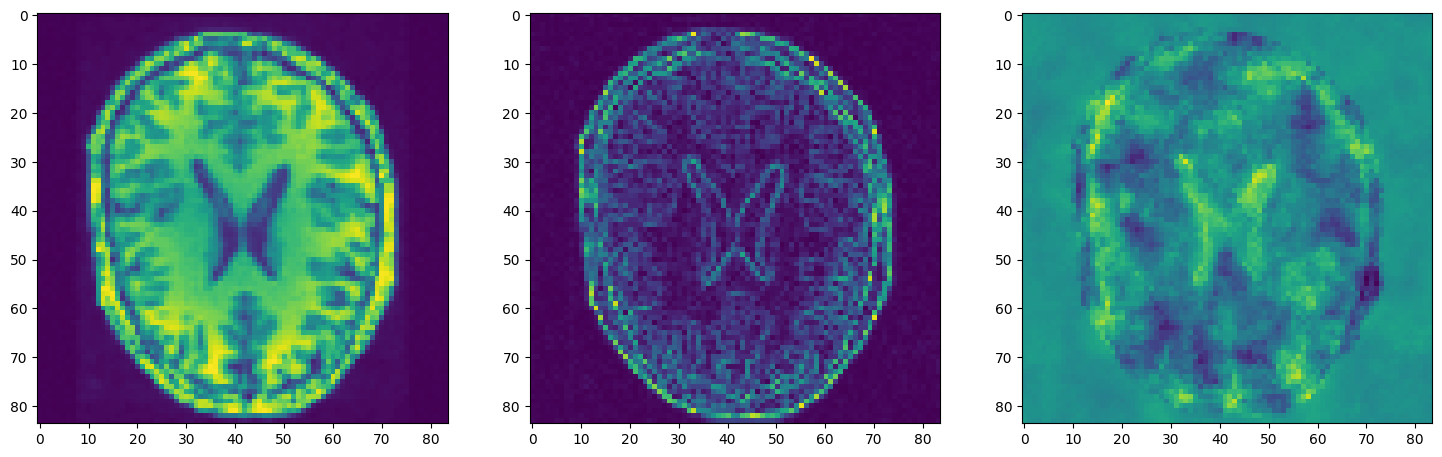

Step 5000, Total loss 0.000080


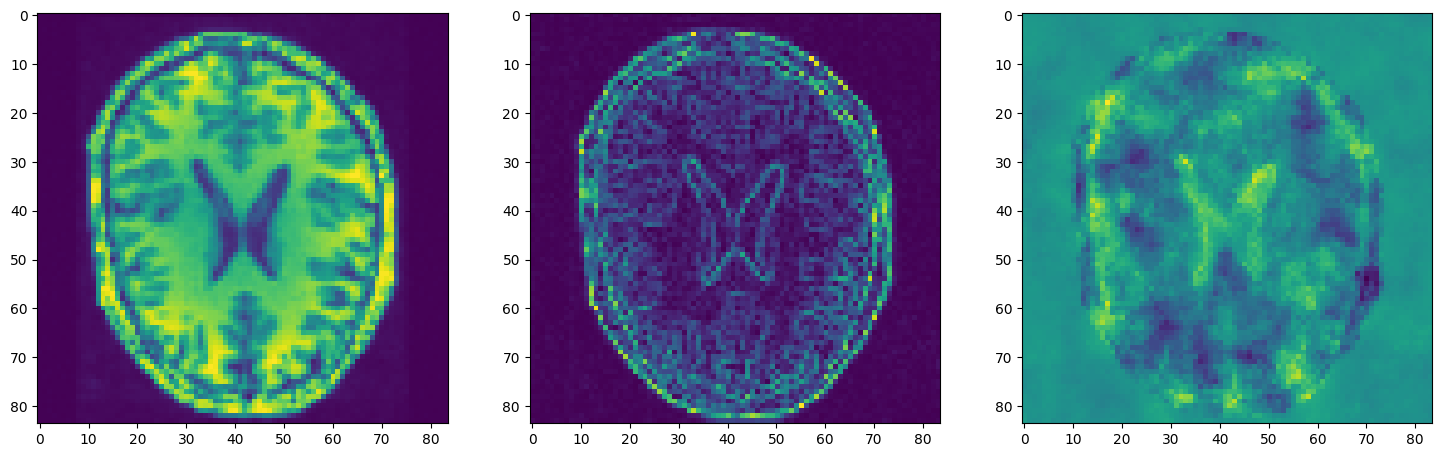

In [24]:
train(model, dataloader, mse)

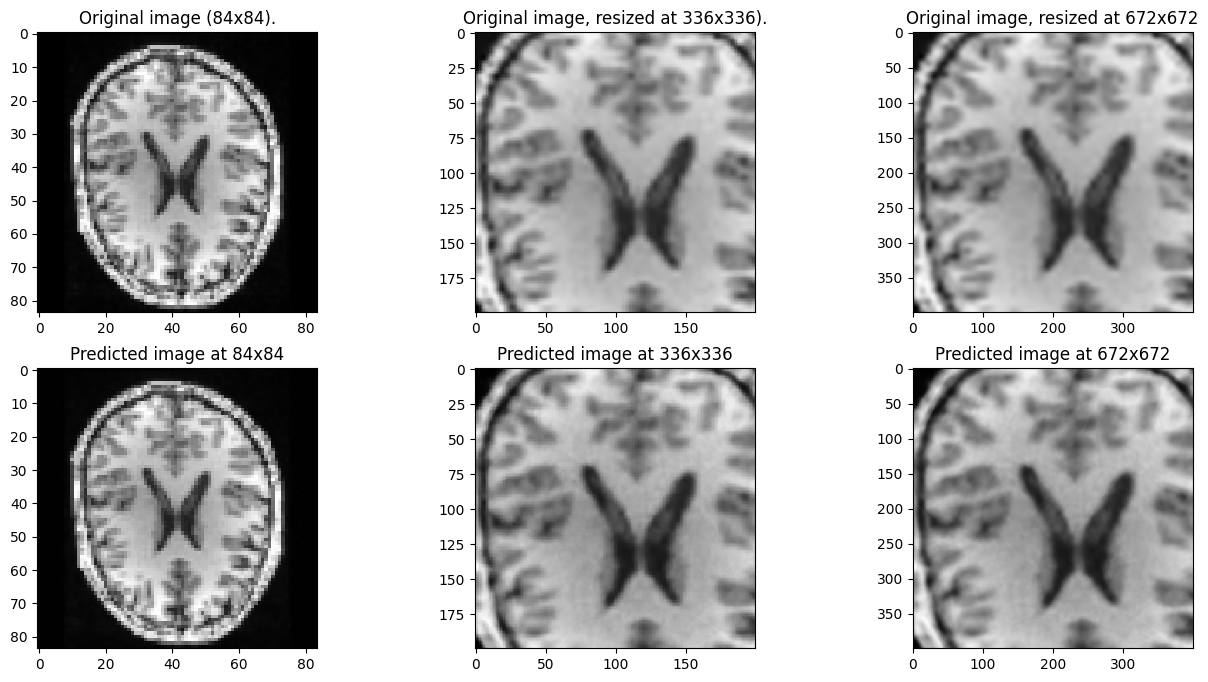

In [25]:
eval_model(model)

# WIRE

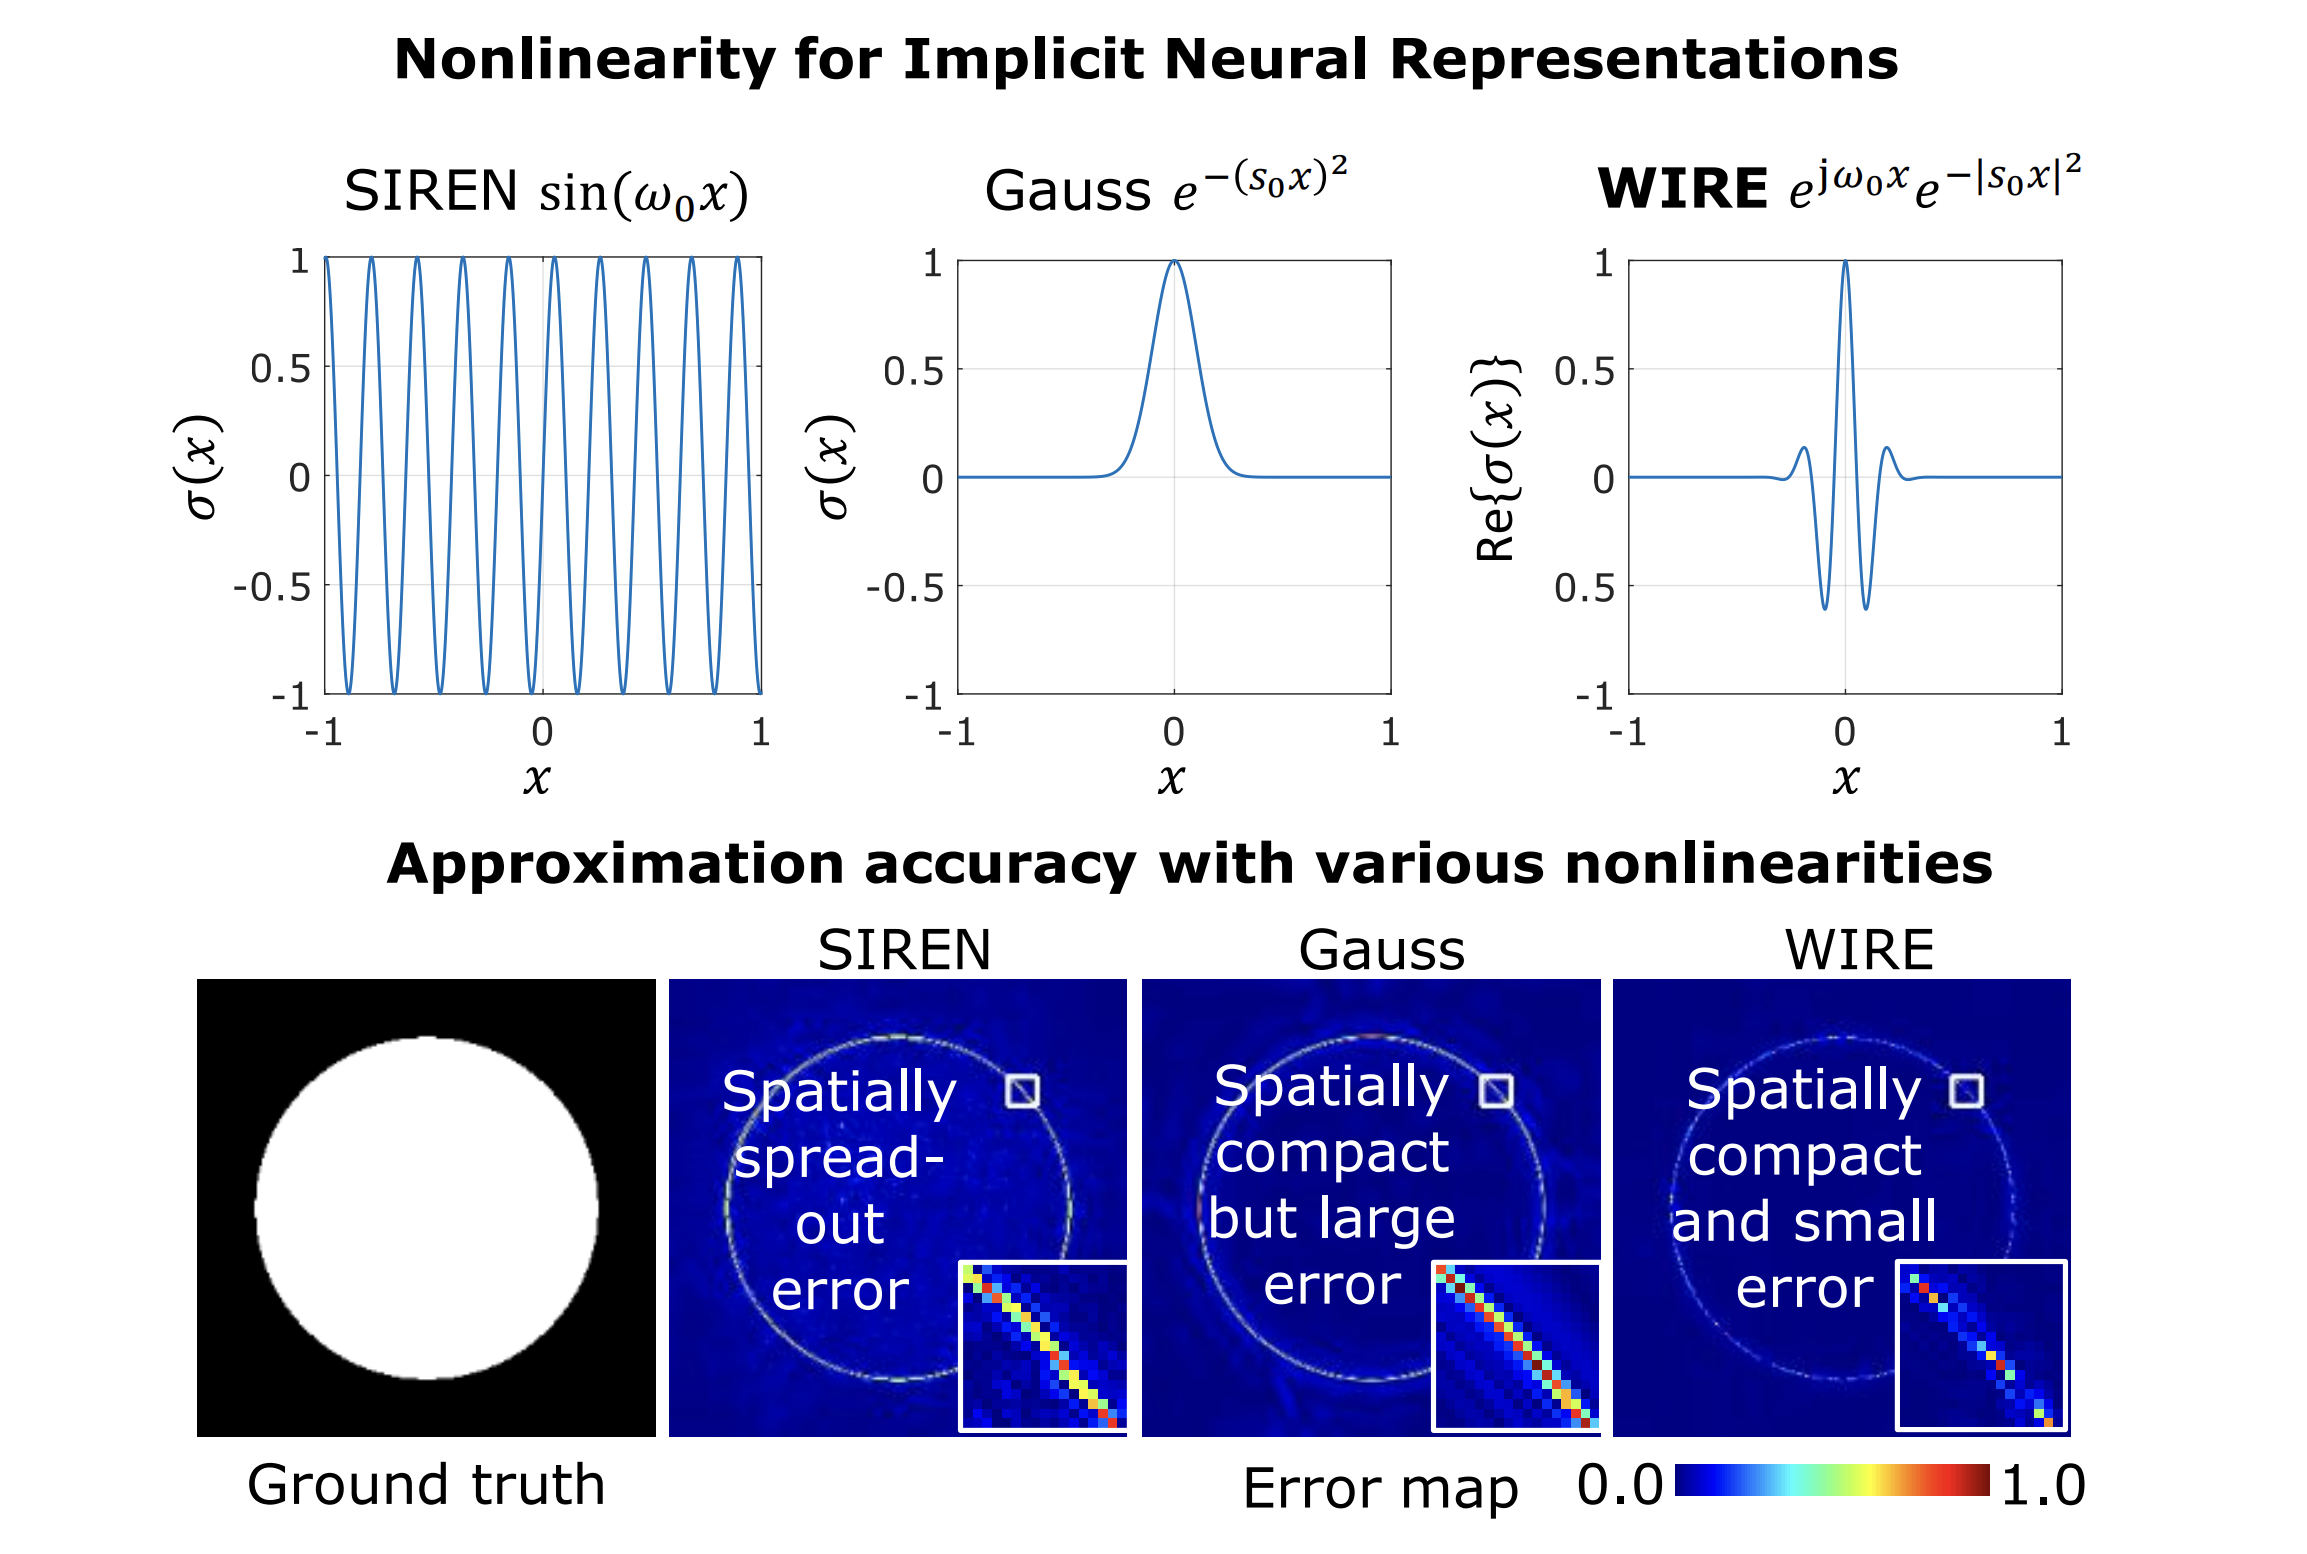
[1]


According to [2], SIRENs can be sensitive to the choice of hyperparameters and be slow to converge. Taking inspiration from classical image processing paradigms, the authors propose a new activation function: the Gabor wavelet[3], where

$$x \rightarrow \phi(x; \omega_0, s_0) = \text{sin}( \omega_0 (W_\omega x + b))e^{-(s_0 (W_s x + b))^2}.$$

In a sense, this activation function is a generalization of SIREN as $s_0 = 0$ is rigourously equivalent.

\[1]: https://www.youtube.com/watch?v=4jI8DZPEfEY&t=189s

\[2]: Saragadam, V., LeJeune, D., Tan, J., Balakrishnan, G., Veeraraghavan, A., & Baraniuk, R. G. (2023). Wire: Wavelet implicit neural representations. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 18507-18516).

\[3]: only the imaginary part of the Gabor wavelet transformed is considered here but its full implementation is possible.

In [26]:
WIRE_OMEGA = 10.0
WIRE_SIGMA = 30.0

class WIRELayer(nn.Module):
    """
        Implicit representation with Gabor nonlinearity
        Implementation based on https://github.com/vishwa91/wire
    """
    def __init__(self, in_size, out_size, wire_omega: float = 30.0, wire_sigma: float = 40.0, **kwargs):
        super().__init__()
        self.omega_0 = wire_omega  # Frequency of wavelet
        self.scale_0 = wire_sigma  # Width of wavelet
        self.freqs = nn.Linear(in_size, out_size, bias=True)
        self.scale = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        omega = self.omega_0 * self.freqs(x)
        scale = self.scale(x) * self.scale_0
        x = torch.cos(omega) * torch.exp(-(scale * scale)) # real part of gabor wavelet
        return x

    
class WIRENet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, 
                 wire_omega=WIRE_OMEGA, wire_sigma=WIRE_SIGMA):
        super().__init__()
        
        self.net = []
        self.net.append(WIRELayer(in_features, hidden_features, 
                                  iwire_omega=wire_omega, wire_sigma=wire_sigma))

        for i in range(hidden_layers):
            self.net.append(WIRELayer(hidden_features, hidden_features, 
                                      wire_omega=wire_omega, wire_sigma=wire_sigma))

        self.net.append(nn.Linear(hidden_features, out_features))
        
        self.net = nn.Sequential(*self.net)

        self.initialize_wire_weights(wire_omega)

    def initialize_wire_weights(self, omega: float):
        """ See SIREN paper supplement Sec. 1.5 for discussion """
        old_weights = self.net[1].freqs.weight.clone()
        with torch.no_grad():
            # First layer initialization
            num_input = self.net[0].freqs.weight.size(-1)
            self.net[0].freqs.weight.uniform_(-1 / num_input, 1 / num_input)
            self.net[0].scale.weight.uniform_(-1 / num_input, 1 / num_input)
            # Subsequent layer initialization based on omega parameter
            for layer in self.net[1:-1]:
                num_input = layer.freqs.weight.size(-1)
                layer.freqs.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
                layer.scale.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            # Final linear layer also uses initialization based on omega parameter
            num_input = self.net[-1].weight.size(-1)
            self.net[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            self.net[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords       

In [27]:
t1 = ImageFitting(84)
dataloader = DataLoader(t1, batch_size=1, pin_memory=True, num_workers=0)

model = WIRENet(in_features=2, out_features=1, hidden_features=256, 
                hidden_layers=4)
model.cuda()

torch.Size([7056, 1]) torch.Size([7056, 2])


WIRENet(
  (net): Sequential(
    (0): WIRELayer(
      (freqs): Linear(in_features=2, out_features=256, bias=True)
      (scale): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): WIRELayer(
      (freqs): Linear(in_features=256, out_features=256, bias=True)
      (scale): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): WIRELayer(
      (freqs): Linear(in_features=256, out_features=256, bias=True)
      (scale): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): WIRELayer(
      (freqs): Linear(in_features=256, out_features=256, bias=True)
      (scale): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): WIRELayer(
      (freqs): Linear(in_features=256, out_features=256, bias=True)
      (scale): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.564944


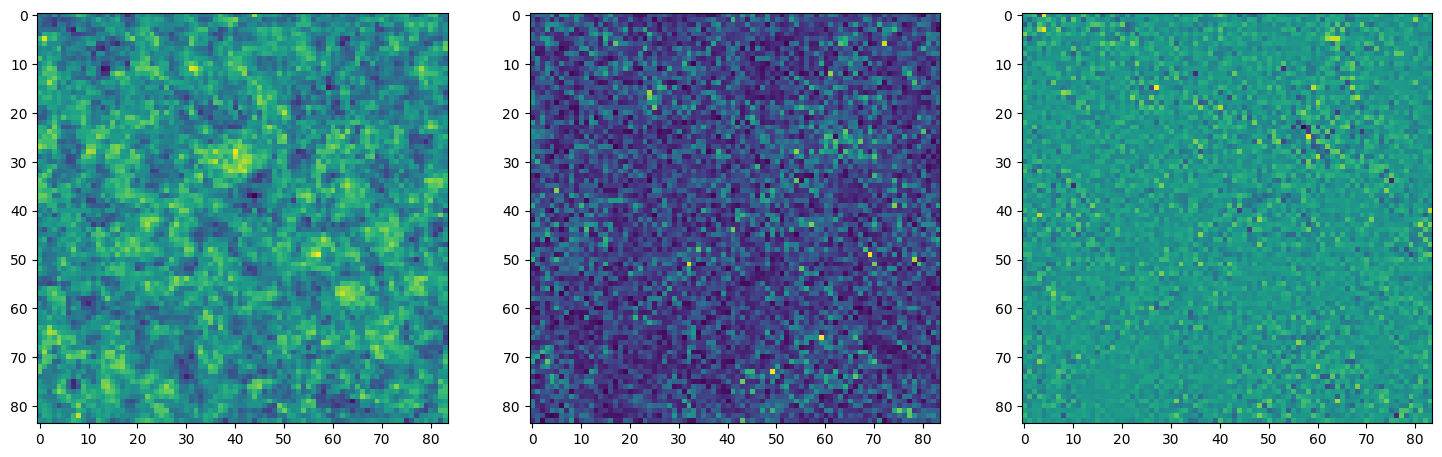

Step 1000, Total loss 0.000000


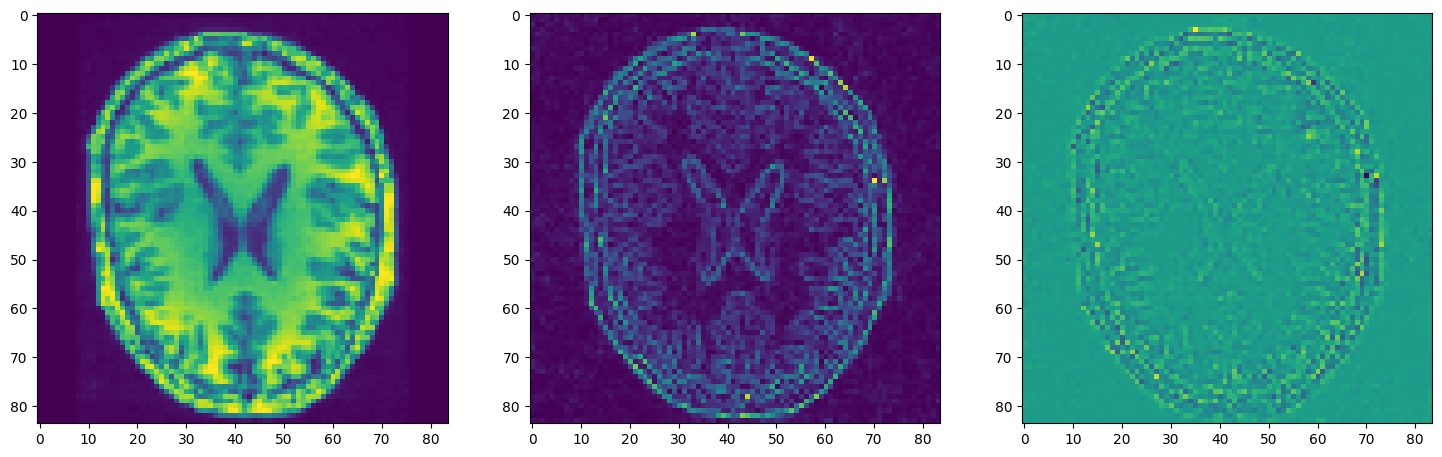

Step 2000, Total loss 0.000000


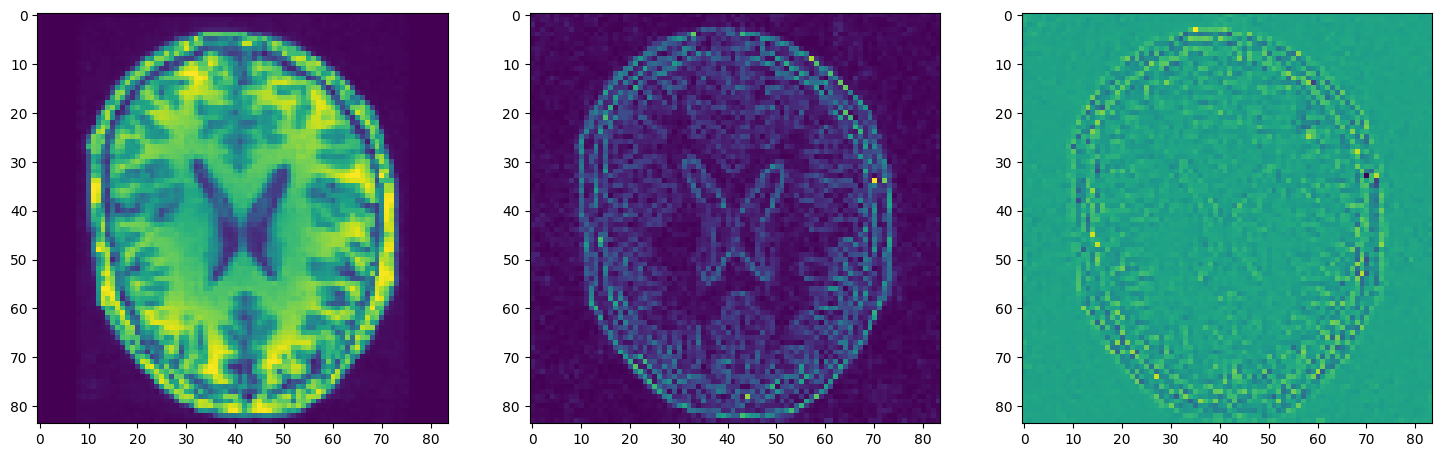

Step 3000, Total loss 0.000002


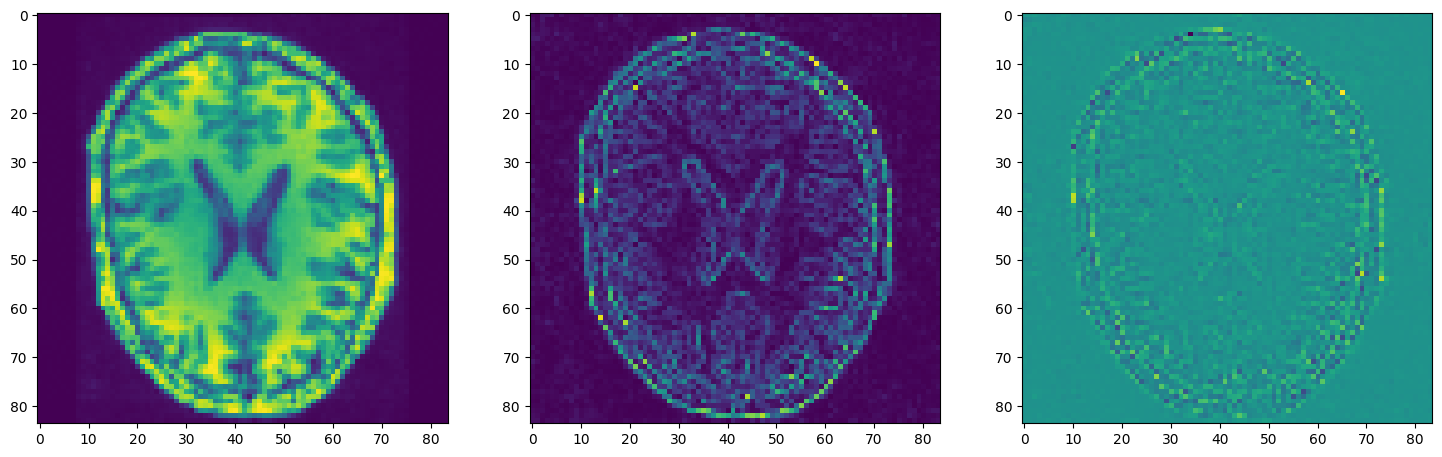

Step 4000, Total loss 0.000000


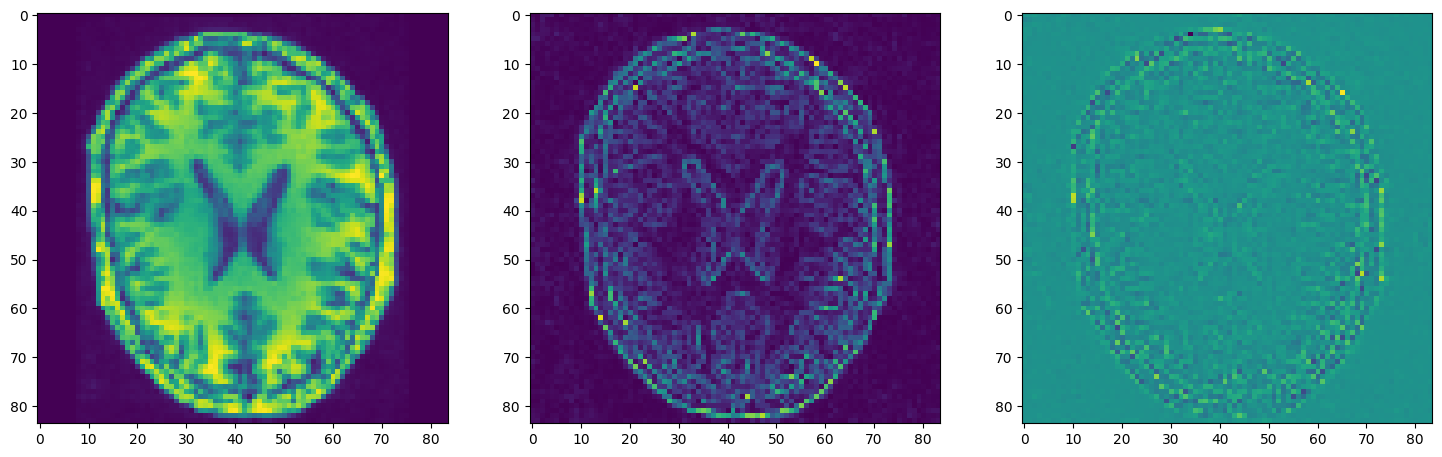

Step 5000, Total loss 0.000000


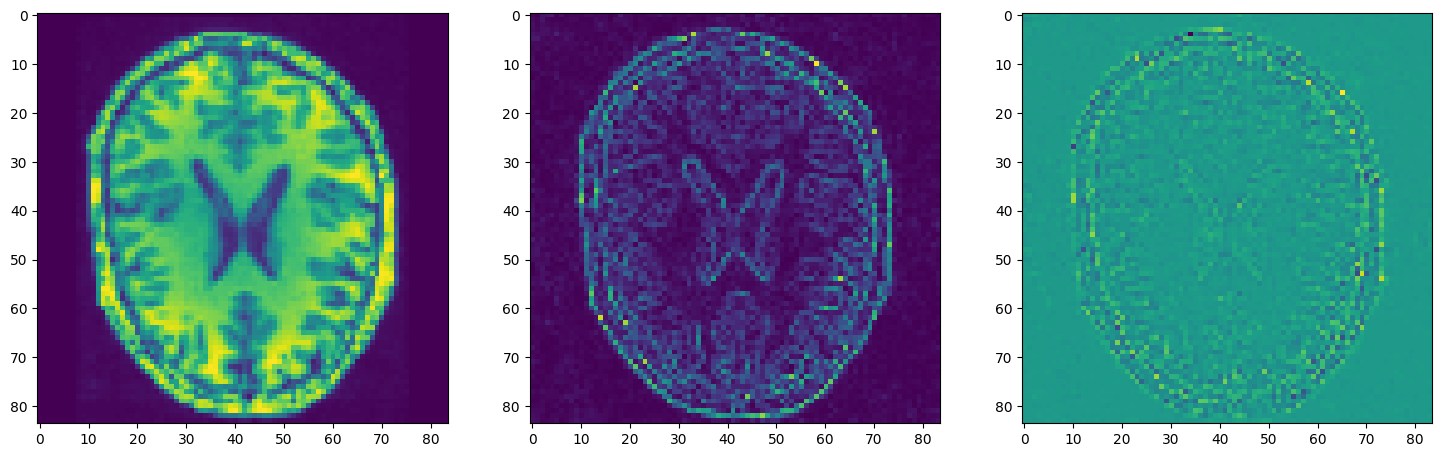

In [28]:
train(model, dataloader, mse)

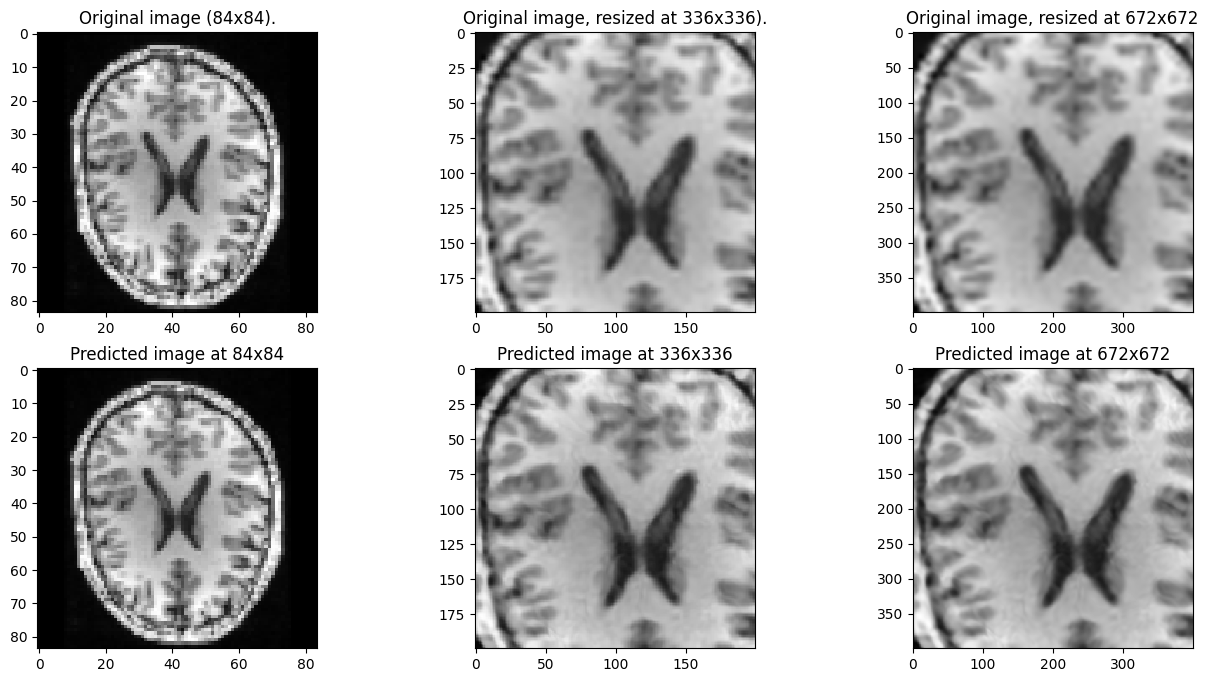

In [29]:
eval_model(model)